In [1]:
# General
import os
import warnings
warnings.filterwarnings ( "ignore" )
from datetime import datetime,timedelta  #time,
import matplotlib.pyplot as plt

# Scientific and data
import numpy as np
import pandas as pd
import  xarray as xr
eps = np.finfo(np.float).eps
# pytorch
import torch.utils.data
torch.manual_seed(8318)
# Local modules
import learning_lidar.utils.global_settings as gs
import learning_lidar.preprocessing.preprocessing as prep
from learning_lidar.utils.proc_utils import Bezier
# %% Helper Functions
def decay_p (t,t0,p0):
	return p0*(np.exp(-(t-t0)/days_decay))
def var_p(p,maxv,minv):
	return 0.25*(1-p/(maxv))/((maxv-minv)/maxv)+0.05*(1-(1-ds_gen_p.p/(maxv))/((maxv-minv)/maxv))
# %% Plotting Settings
import learning_lidar.generation.generation_utils as gen_utils
import calendar
import seaborn as sns
sns.set_theme()
gs.set_visualization_settings()
# %%

## Load extended calibration database

In [2]:
station_name = 'haifa'
station = gs.Station (station_name = station_name )
wavelengths =gs.LAMBDA_nm().get_elastic()

start_date = datetime ( 2017 , 9 , 1 )
end_date = datetime ( 2017 , 10 , 31 ,23,59,30)
data_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(os.curdir))), 'data')

ds_extended_name = f"dataset_{station_name}_{start_date.strftime ( '%Y-%m-%d' )}_{end_date.strftime ( '%Y-%m-%d' )}_extended.nc"
ds_path_extended = os.path.join(data_folder,ds_extended_name)
ds_extended = prep.load_dataset ( ds_path_extended)

csv_extended_name = f"dataset_{station_name}_{start_date.strftime ( '%Y-%m-%d' )}_{end_date.strftime ( '%Y-%m-%d' )}_extended.csv"
csv_path_extended = os.path.join(data_folder,csv_extended_name)

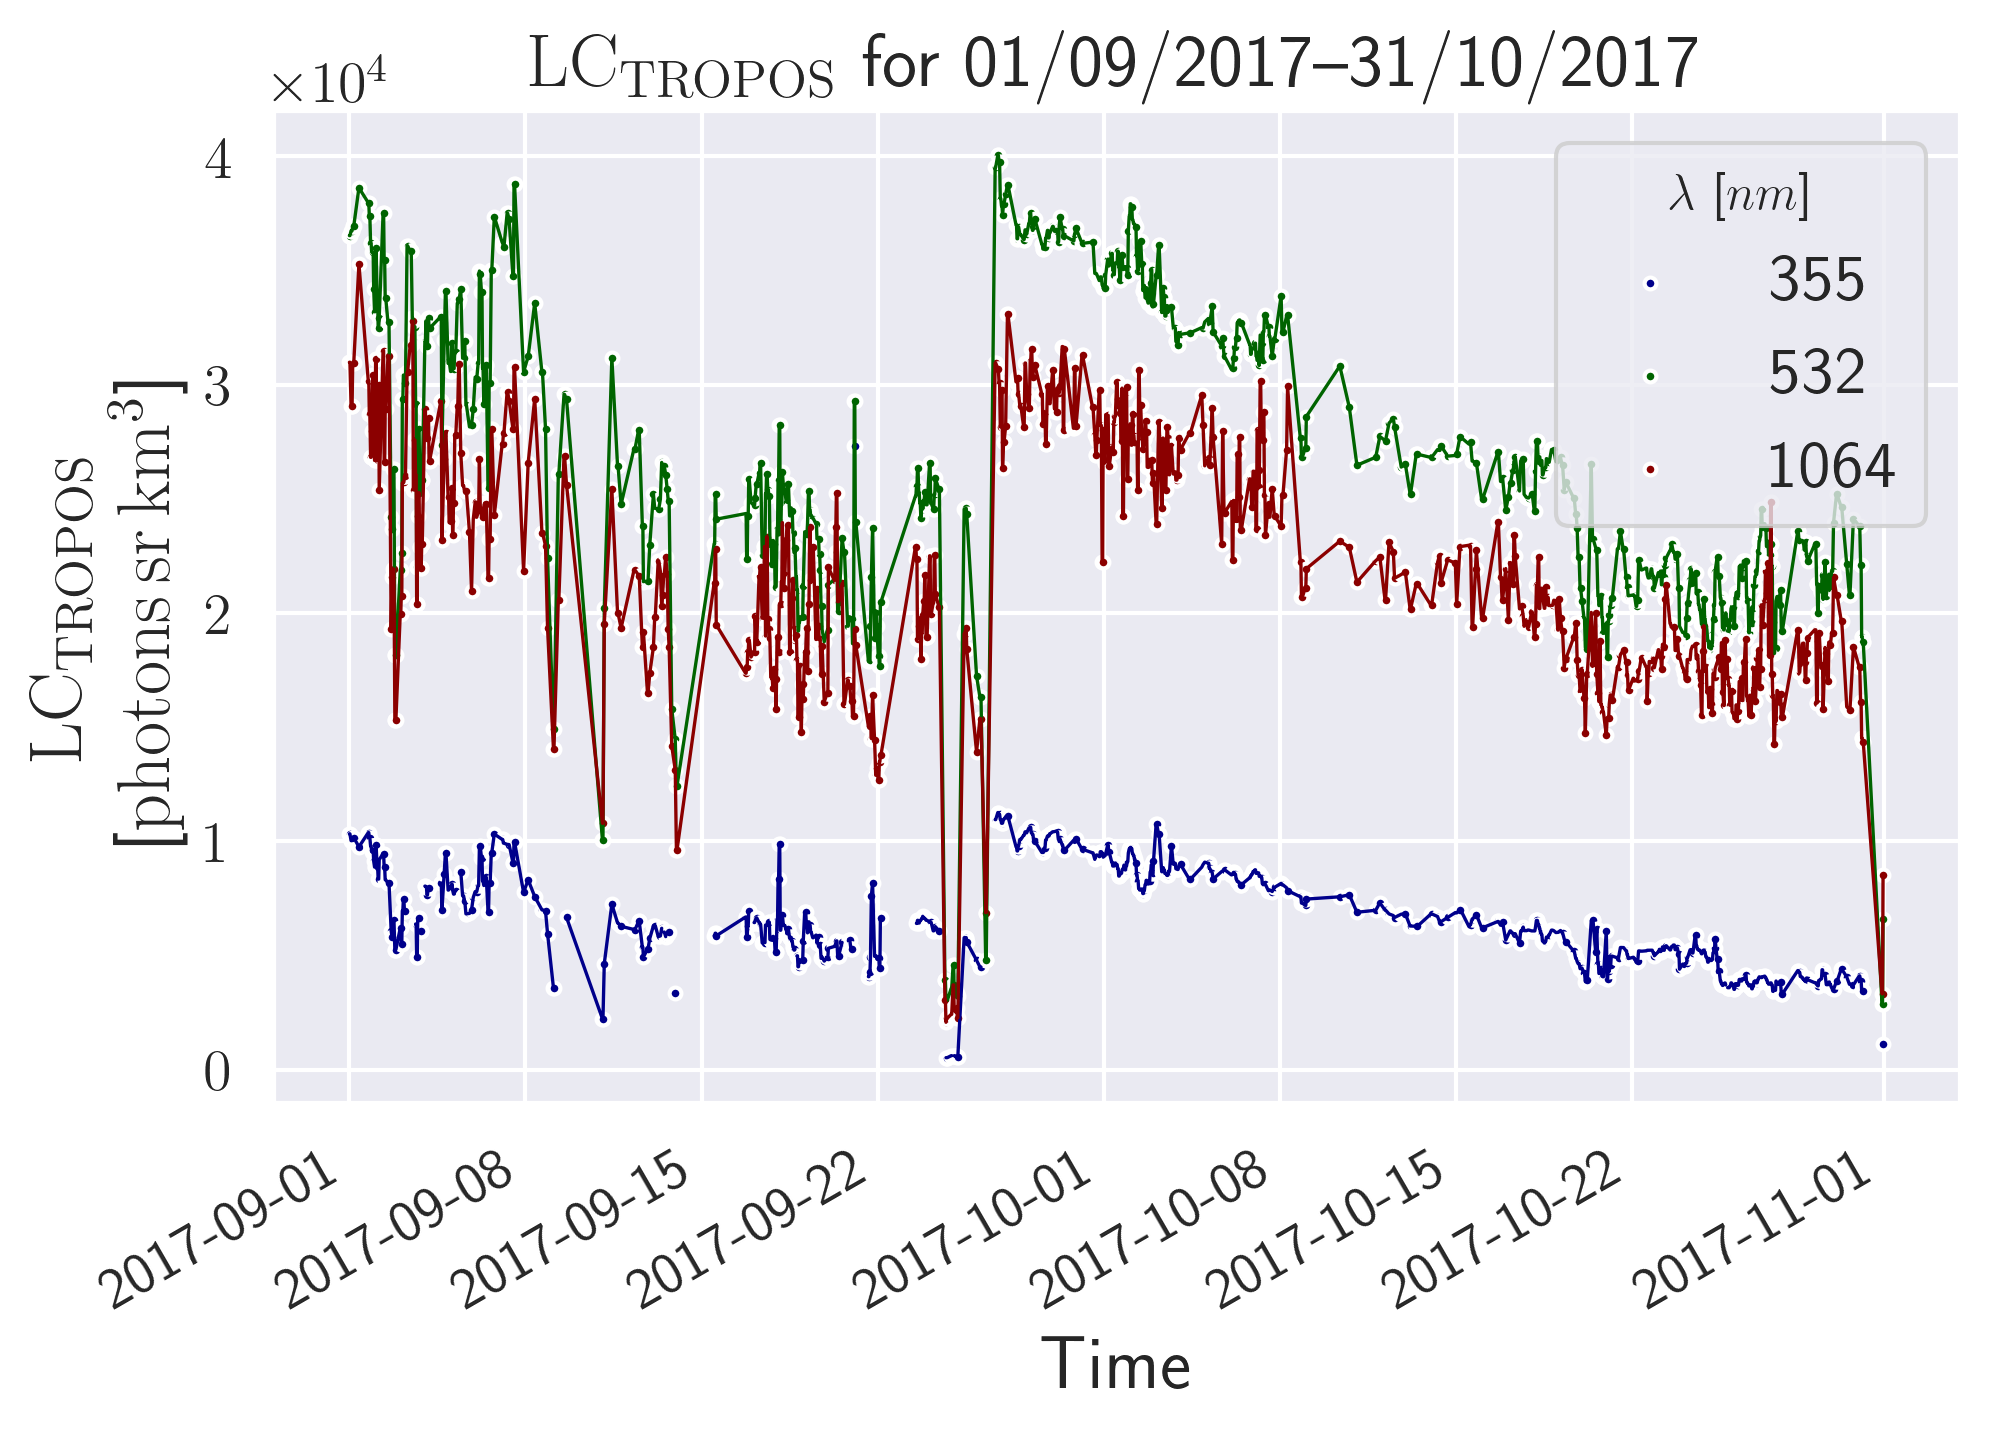

In [3]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(7,5))
ds_extended.LC.plot(ax=ax,hue='Wavelength',linewidth=0.8)
ds_extended.plot.scatter(ax=ax,y='LC',x='Time',
                         hue='Wavelength',
                         s=8,hue_style ='discrete',edgecolor='w')
ax.set_title(fr"{ds_extended.LC.long_name} for {start_date.strftime('%d/%m/%Y' )}--{end_date.strftime('%d/%m/%Y' )}")
ax.ticklabel_format(axis='y', style="sci",scilimits=(0,0))
plt.tight_layout()
plt.show()

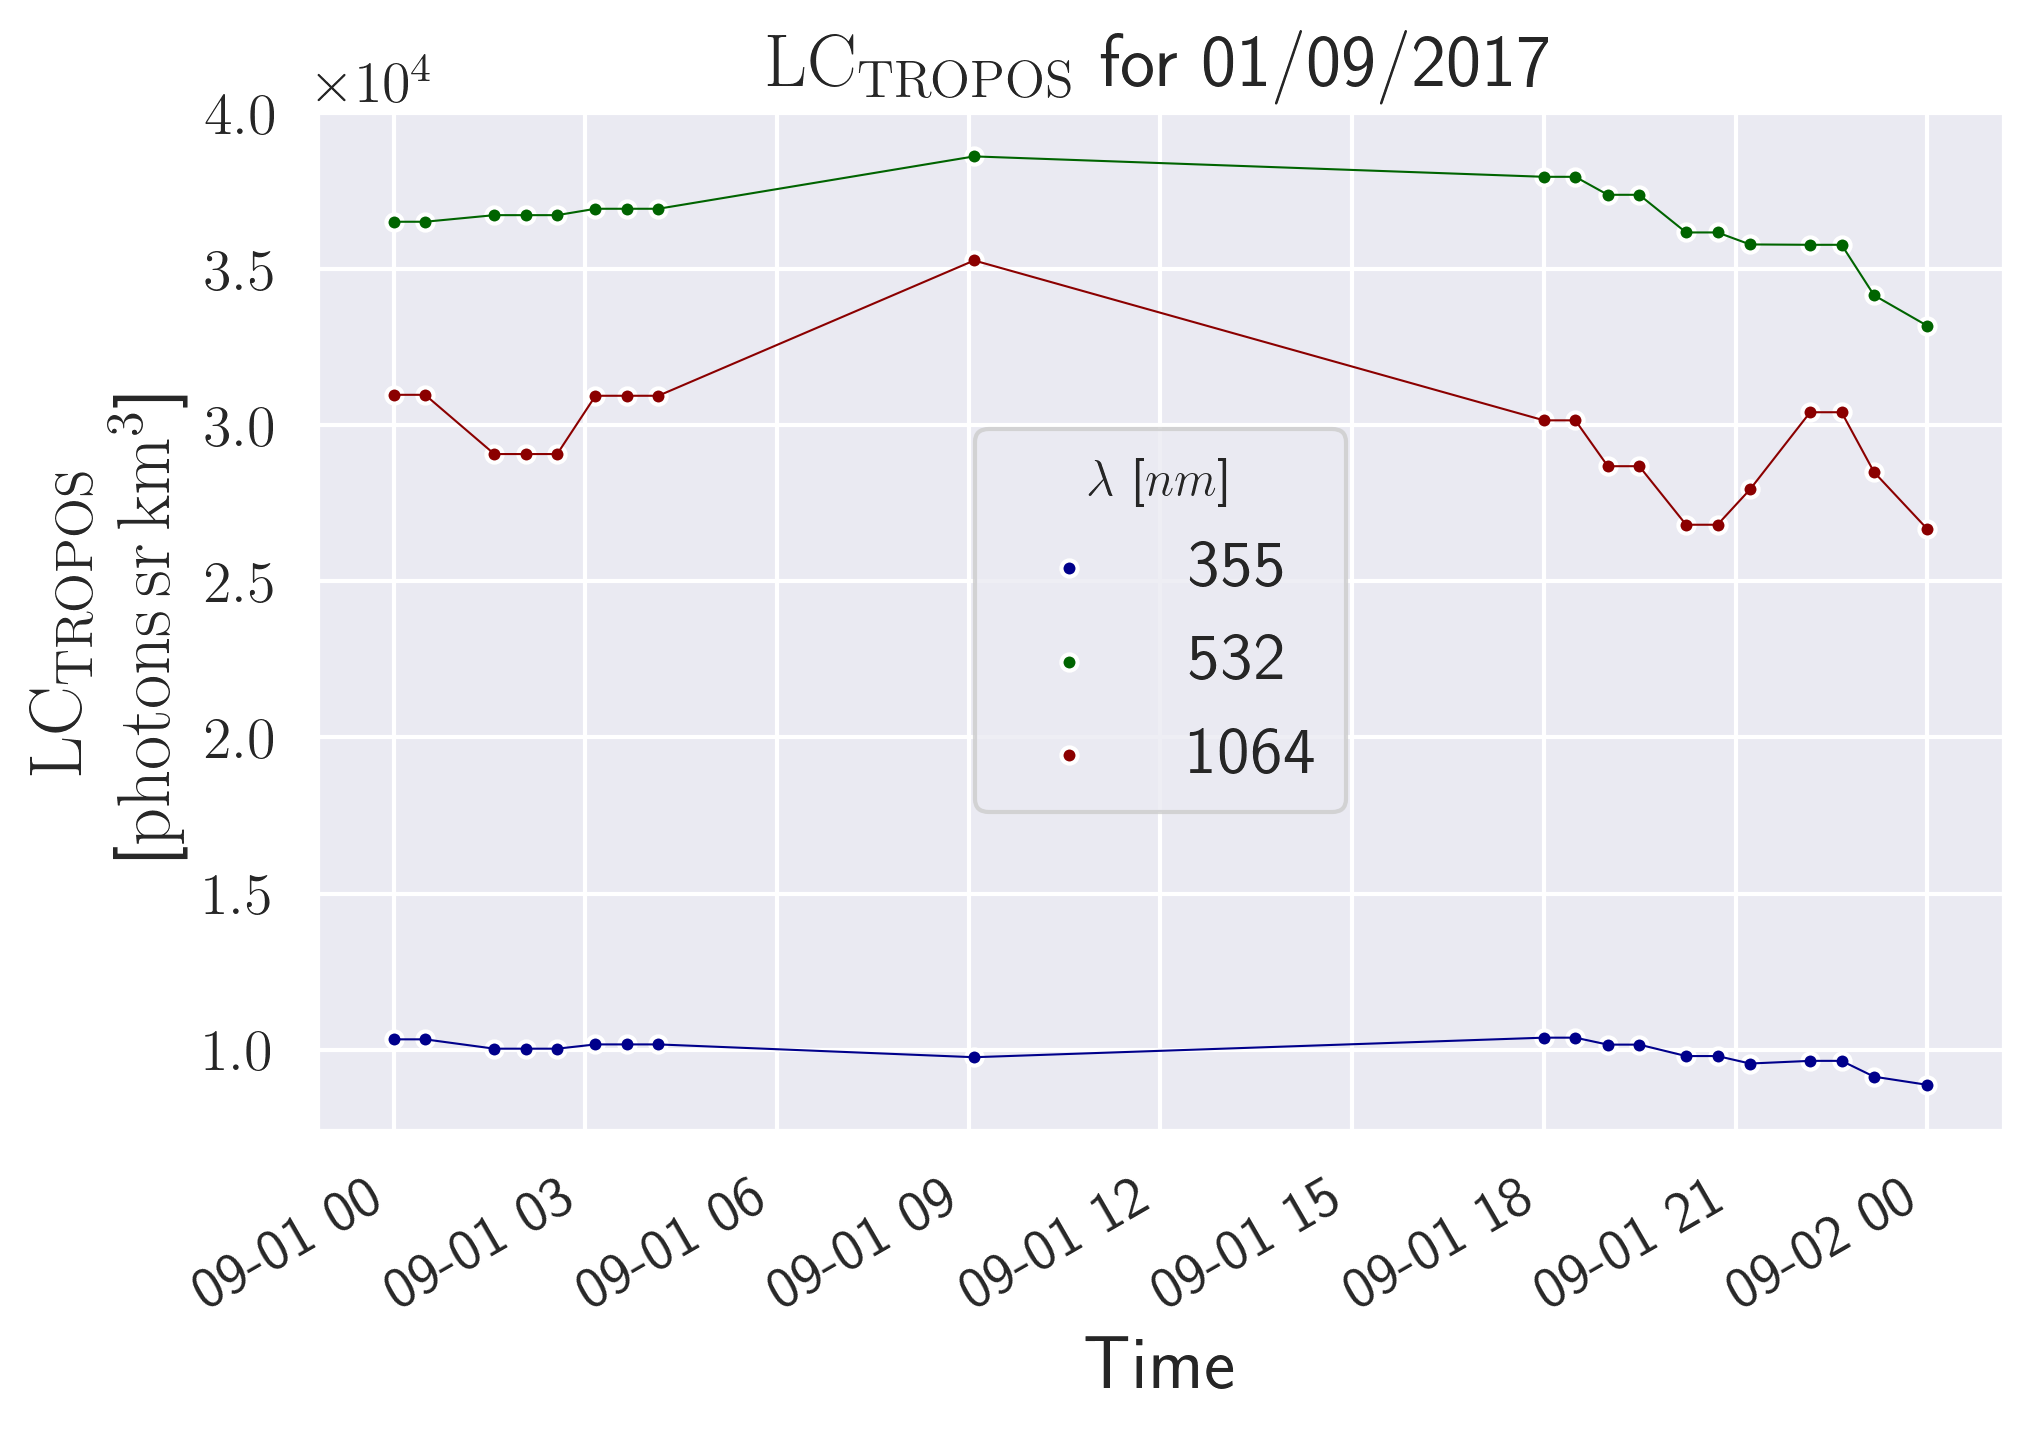

In [4]:
cur_day = datetime(2017,9,1)
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(7,5))
ds_extended.sel(Time=slice(cur_day,cur_day+timedelta(hours = 24))).LC.\
    plot(ax=ax,hue='Wavelength',linewidth=0.5)
ds_extended.sel(Time=slice(cur_day,cur_day+timedelta(hours = 24))).\
    plot.scatter(ax=ax,y='LC',x='Time', hue='Wavelength',s=15,hue_style ='discrete',edgecolor='w')
ax.set_title(fr"{ds_extended.LC.long_name} for {cur_day.strftime('%d/%m/%Y' )}")
ax.ticklabel_format(axis='y', style="sci",scilimits=(0,0))
plt.tight_layout()
plt.show()

### Creating pattern of laser power through days
#### 1. The lidar factor is dependent on optical and geometrical values of the system.
#### 2. From the LC retrieved by TROPOS it seems as it has an exponential decay through the period.
#### 3. Therefore, first generating decay power $p(t)=p_0\cdot\exp(-\frac{t-t_0}{t_{decay}})$
#### 4. Then calculating upper and lower bounding curves of interval of confidence. The interval of confidence is  set as $[\pm5\%,\pm25\% ]$. Higher confidence is for higher power values (meaning small interval of confidence).
#### 4. Then the new power is randomly generated withing the interval of confidence per time $t$

In [5]:
# Set the times for generating random powers.
freq_H = 5 # choose some hourly frequency e.g. 3,4,7 hrs...
time_indx = pd.date_range(start = start_date, end = end_date,freq = f'{freq_H}H')
if time_indx[-1]<end_date:
	# This is to make sure the closing time is at least the end_date.
	# If not then taking another period of freq_H, to make sure the final interpolation
	# will have generated power values for the whole period.
	final_dt = time_indx[-1]+timedelta(hours = freq_H)
	final_dtidx = pd.DatetimeIndex(data =[final_dt])
	time_indx = time_indx.append(final_dtidx)
elif time_indx[-1]==end_date:
	final_dt=end_date
df_times = pd.DataFrame(time_indx,columns = ['date'])
bins_per_day = timedelta(days = 1)/timedelta(hours = freq_H)
df_times['t_day']=(df_times.index/bins_per_day).values

# Set parameters for generating a decay power pattern p(t)
days_decay = 70
peak_days = np.array([-10,40])
period1 = (df_times.t_day>=peak_days[0]) & (df_times.t_day<peak_days[1])
period2 = (df_times.t_day>=peak_days[1])
max_powers = [15000,45000,35000]
ds_chans = []
for wavelength,p0 in zip(wavelengths,max_powers):
	c1 = df_times[period1].apply(lambda row: decay_p(row.t_day,peak_days[0],p0), axis = 1 ,result_type = 'expand')
	c2 = df_times[period2].apply(lambda row: decay_p(row.t_day,peak_days[1],p0), axis = 1 ,result_type = 'expand')
	ds_chans.append(xr.Dataset (
    data_vars = {'p' : (('Time') , pd.concat([c1,c2])) ,
                 'lambda_nm' : ('Wavelength' , np.uint16 ( [ wavelength ] ))
                 } ,
    coords = {'Time' : df_times.date.values ,
              'Wavelength' : np.uint16 ( [ wavelength ] )
                  }))
ds_gen_p = xr.concat ( ds_chans , dim = 'Wavelength' )
ds_gen_p.Wavelength.attrs = {'long_name' : r'$\lambda$','units' :r'$nm$'}
ds_gen_p.p.attrs = {'units' : r'$\rm{photons\,sr\,km^3}$' , 'long_name' : r'$\rm{ LC_{generated}}$' ,
                           'info' : 'LC - Lidar constant - from generation'}
ds_gen_p =\
	ds_gen_p.assign(
	p_ubound =
xr.apply_ufunc(lambda p,maxv,minv: p+p*var_p(p,maxv,minv),
               ds_gen_p.p,ds_gen_p.p.max(dim='Time'),
               ds_gen_p.p.min(dim='Time'), keep_attrs = True),
	p_lbound =
xr.apply_ufunc(lambda p,maxv,minv: p-p*var_p(p,maxv,minv),
               ds_gen_p.p,ds_gen_p.p.max(dim='Time'),
               ds_gen_p.p.min(dim='Time'), keep_attrs = True))

ds_gen_p = ds_gen_p.assign( p_new = xr.apply_ufunc(lambda lbound,ubound,rand: lbound+ (ubound-lbound)*rand,
               ds_gen_p.p_lbound,ds_gen_p.p_ubound,np.random.rand(3,ds_gen_p.Time.size),keep_attrs = True))

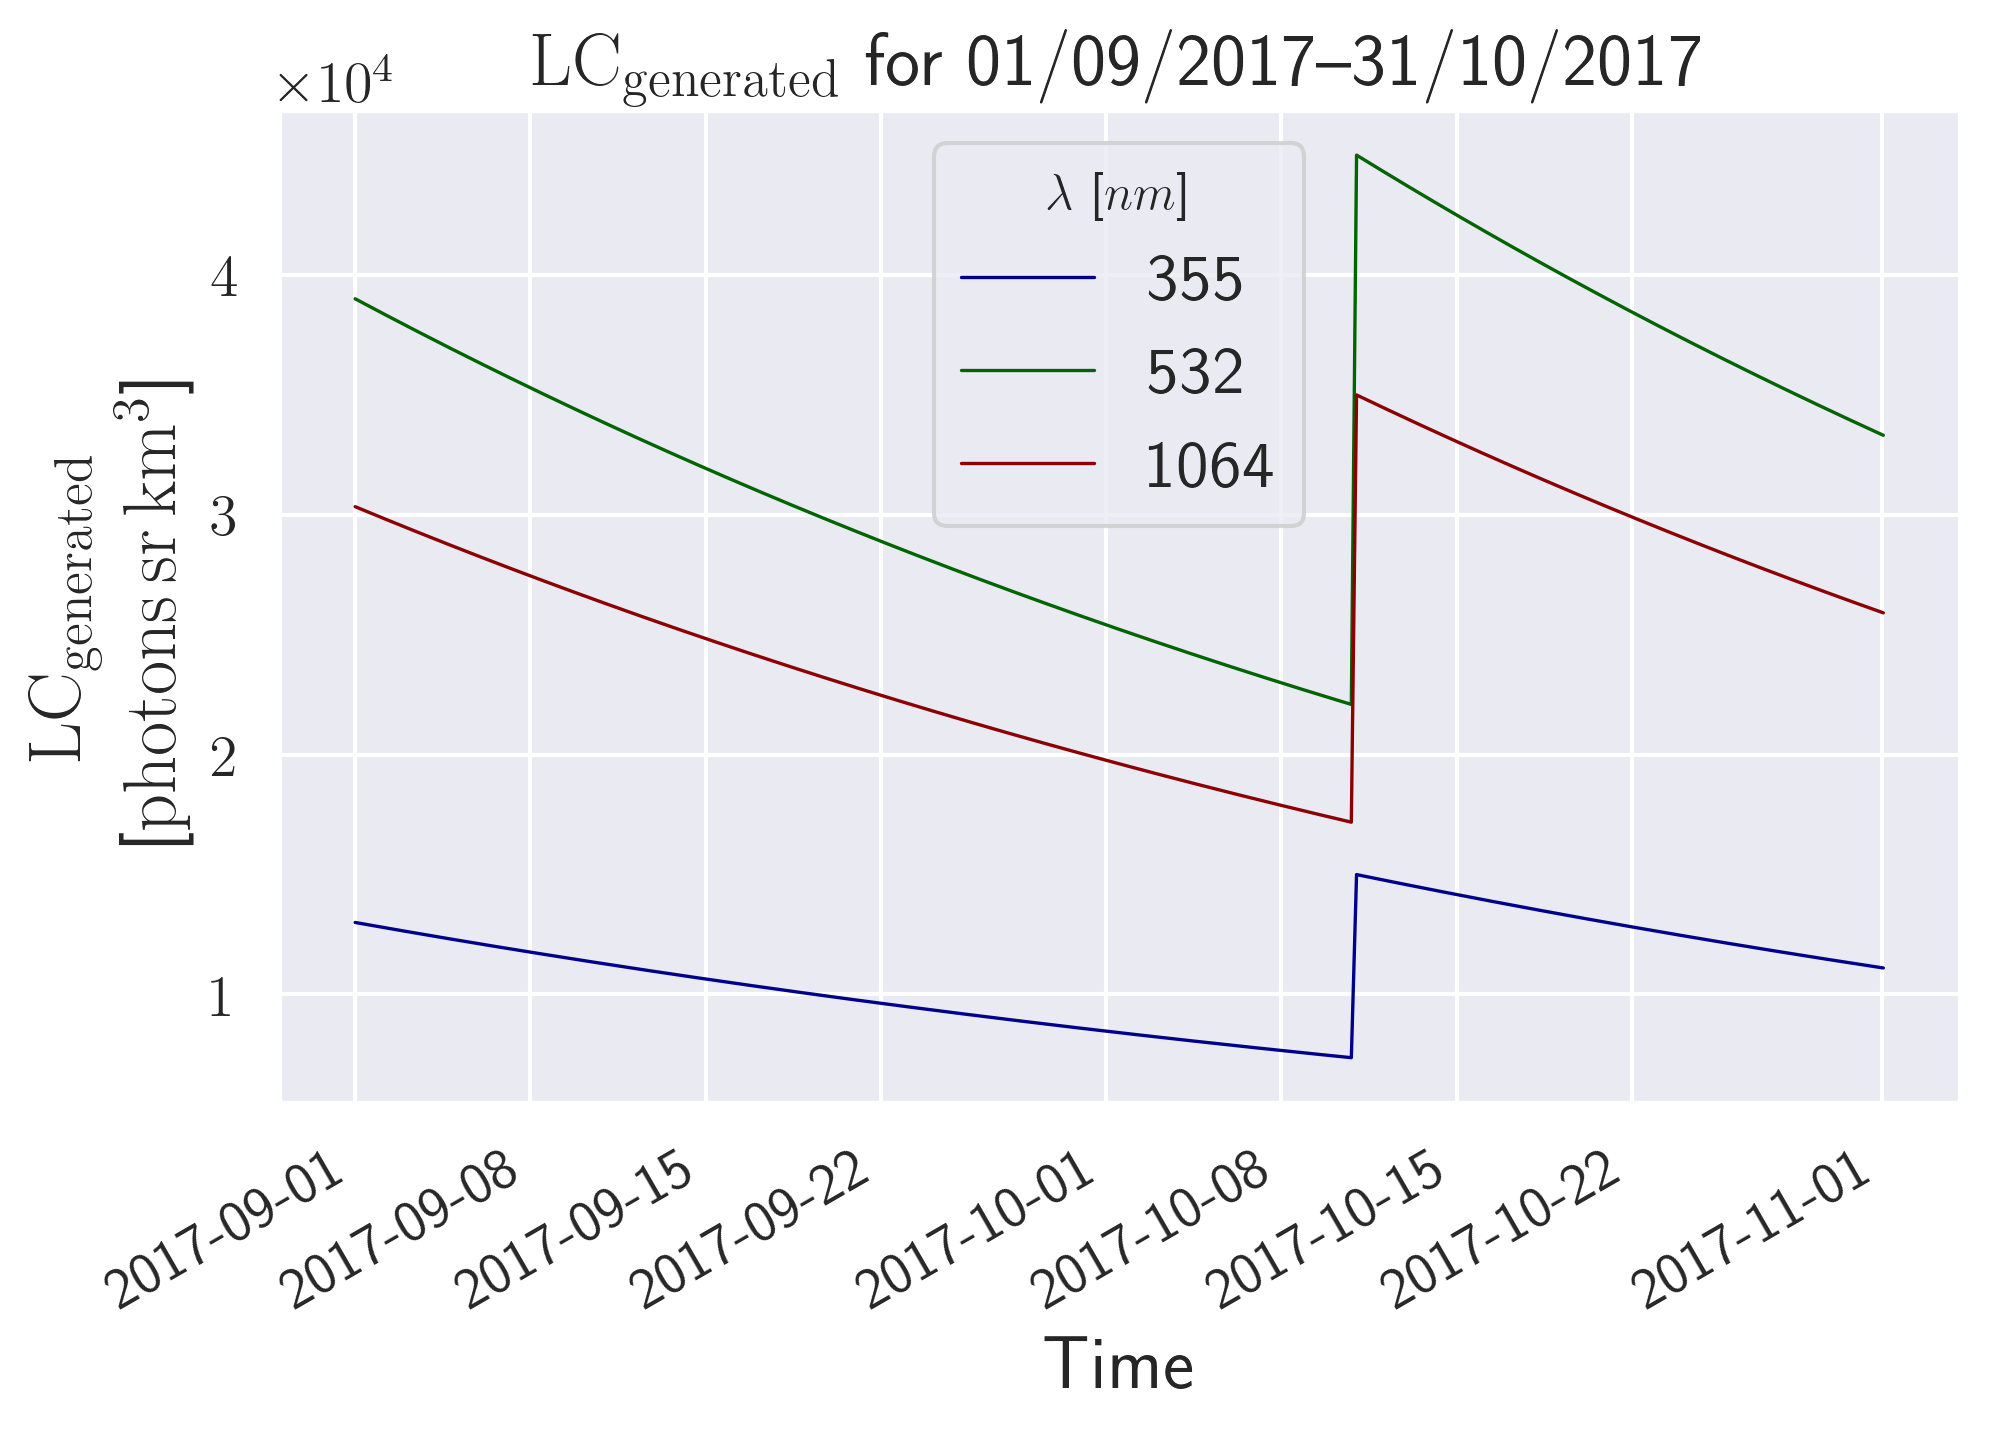

In [6]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(7,5))
ds_gen_p.p.plot(ax=ax ,hue='Wavelength',linewidth=0.8)
ax.set_title(fr"{ds_gen_p.p.long_name} for {start_date.strftime('%d/%m/%Y' )}--{end_date.strftime('%d/%m/%Y' )}")
ax.ticklabel_format(axis='y', style="sci",scilimits=(0,0))
plt.tight_layout()
plt.show()

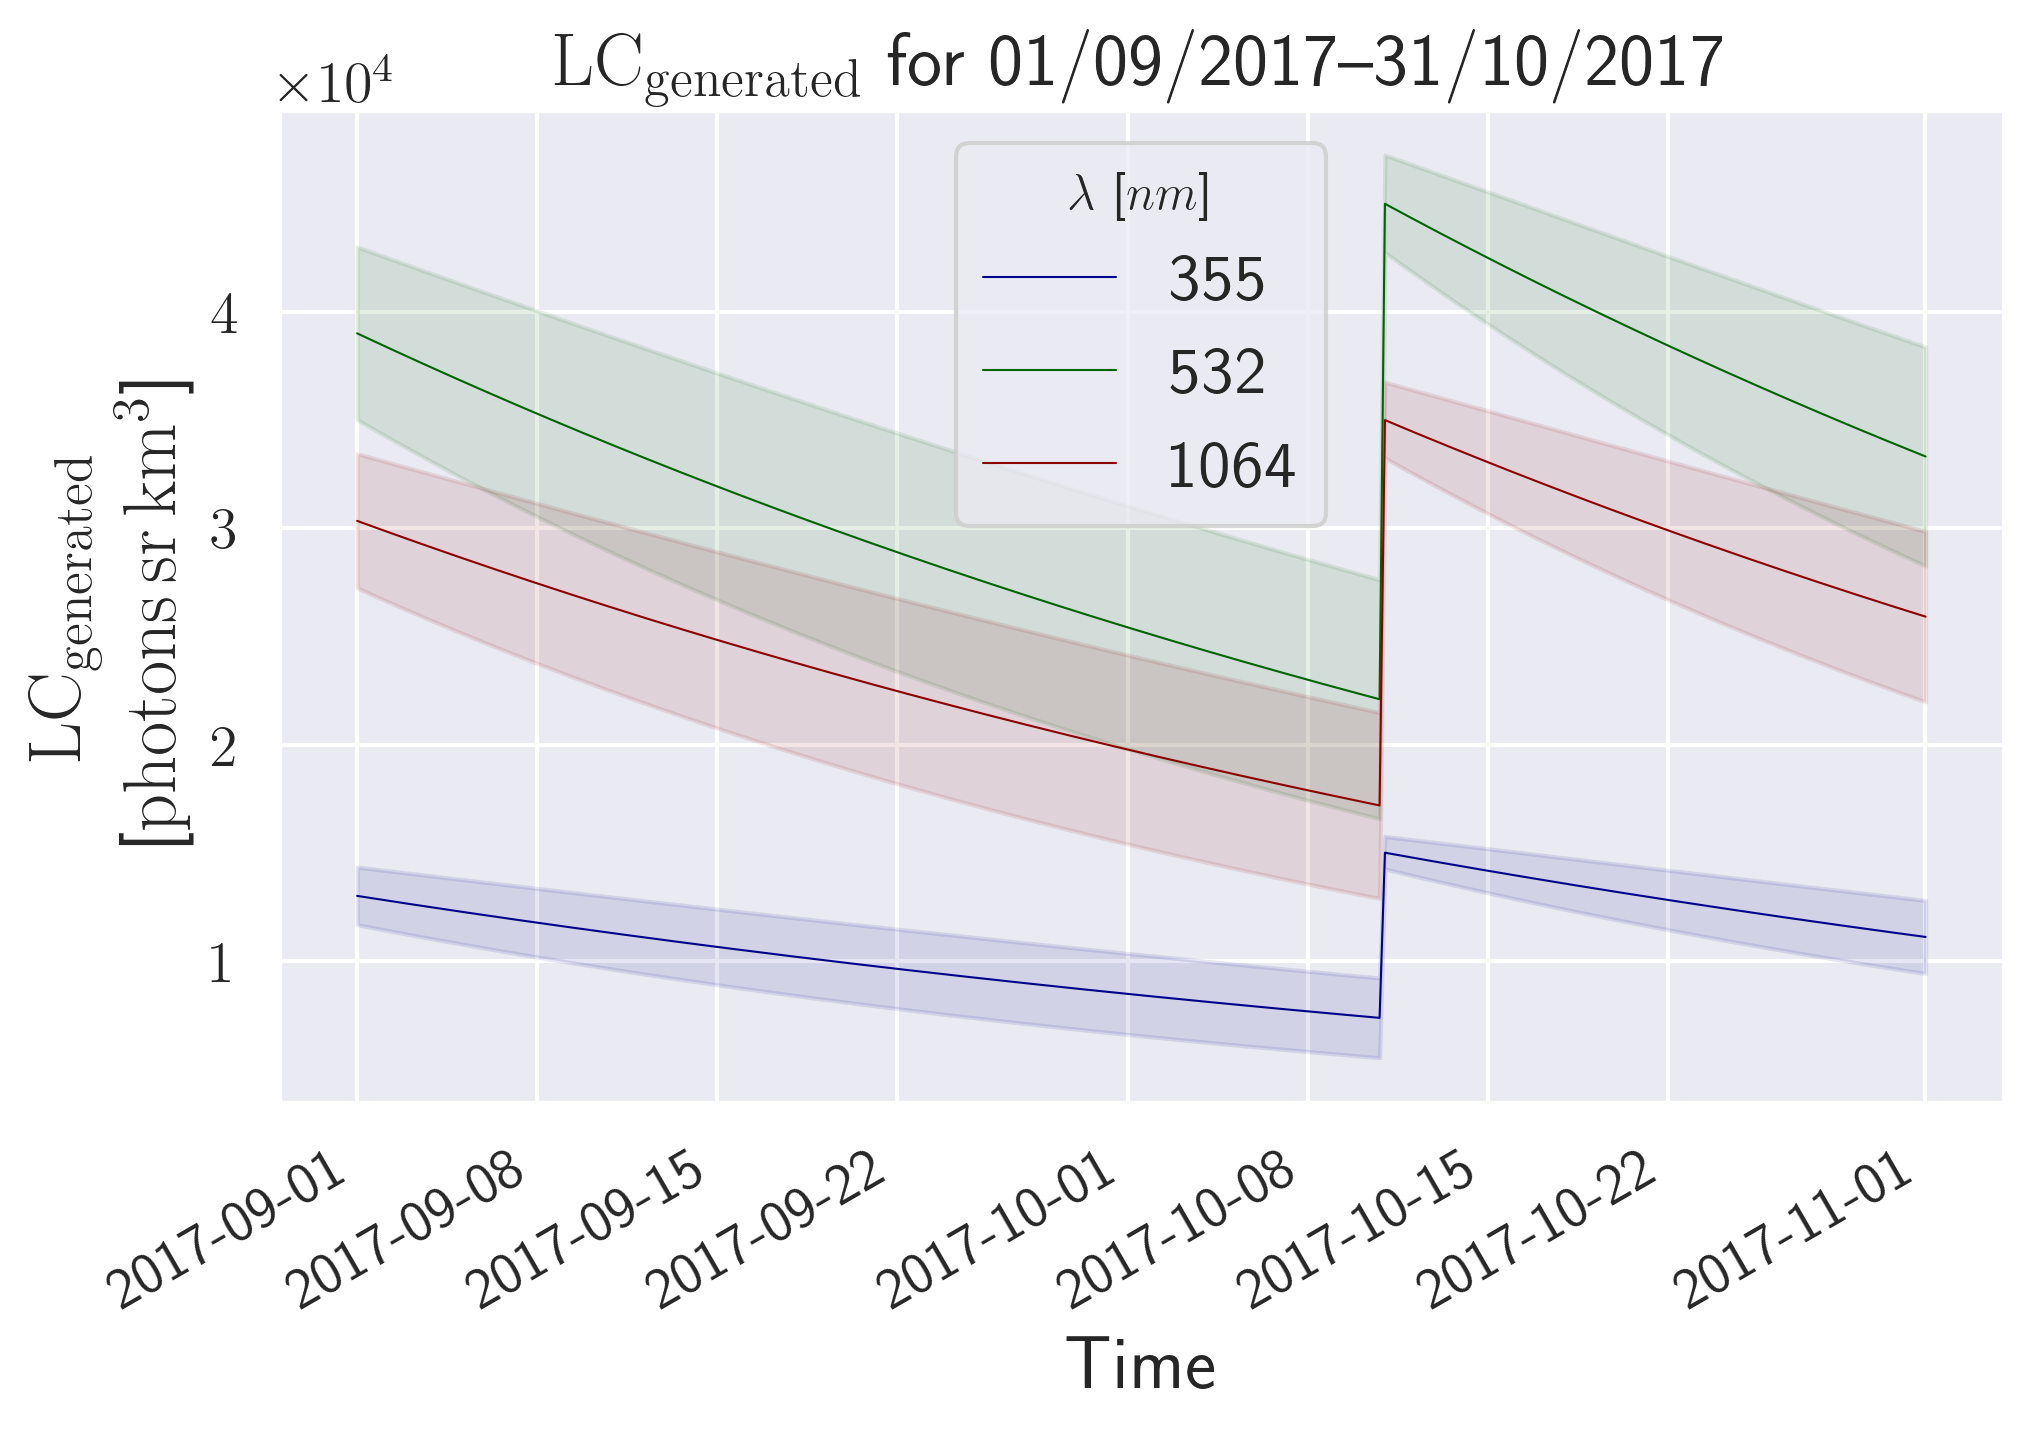

In [7]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(7,5))
ds_gen_p.p.plot(ax=ax,hue='Wavelength',linewidth=0.5)
for wavelength,c in zip(wavelengths,gs.COLORS):
	ax.fill_between(ds_gen_p.Time.values,
	                 ds_gen_p.p_lbound.sel(Wavelength= wavelength).values,
	                 ds_gen_p.p_ubound.sel(Wavelength=wavelength).values,
	                 color=c, alpha=.1)
ax.set_title(fr"{ds_gen_p.p.long_name} for {start_date.strftime('%d/%m/%Y' )}--{end_date.strftime('%d/%m/%Y' )}")
ax.ticklabel_format(axis='y', style="sci",scilimits=(0,0))
plt.tight_layout()
plt.show()

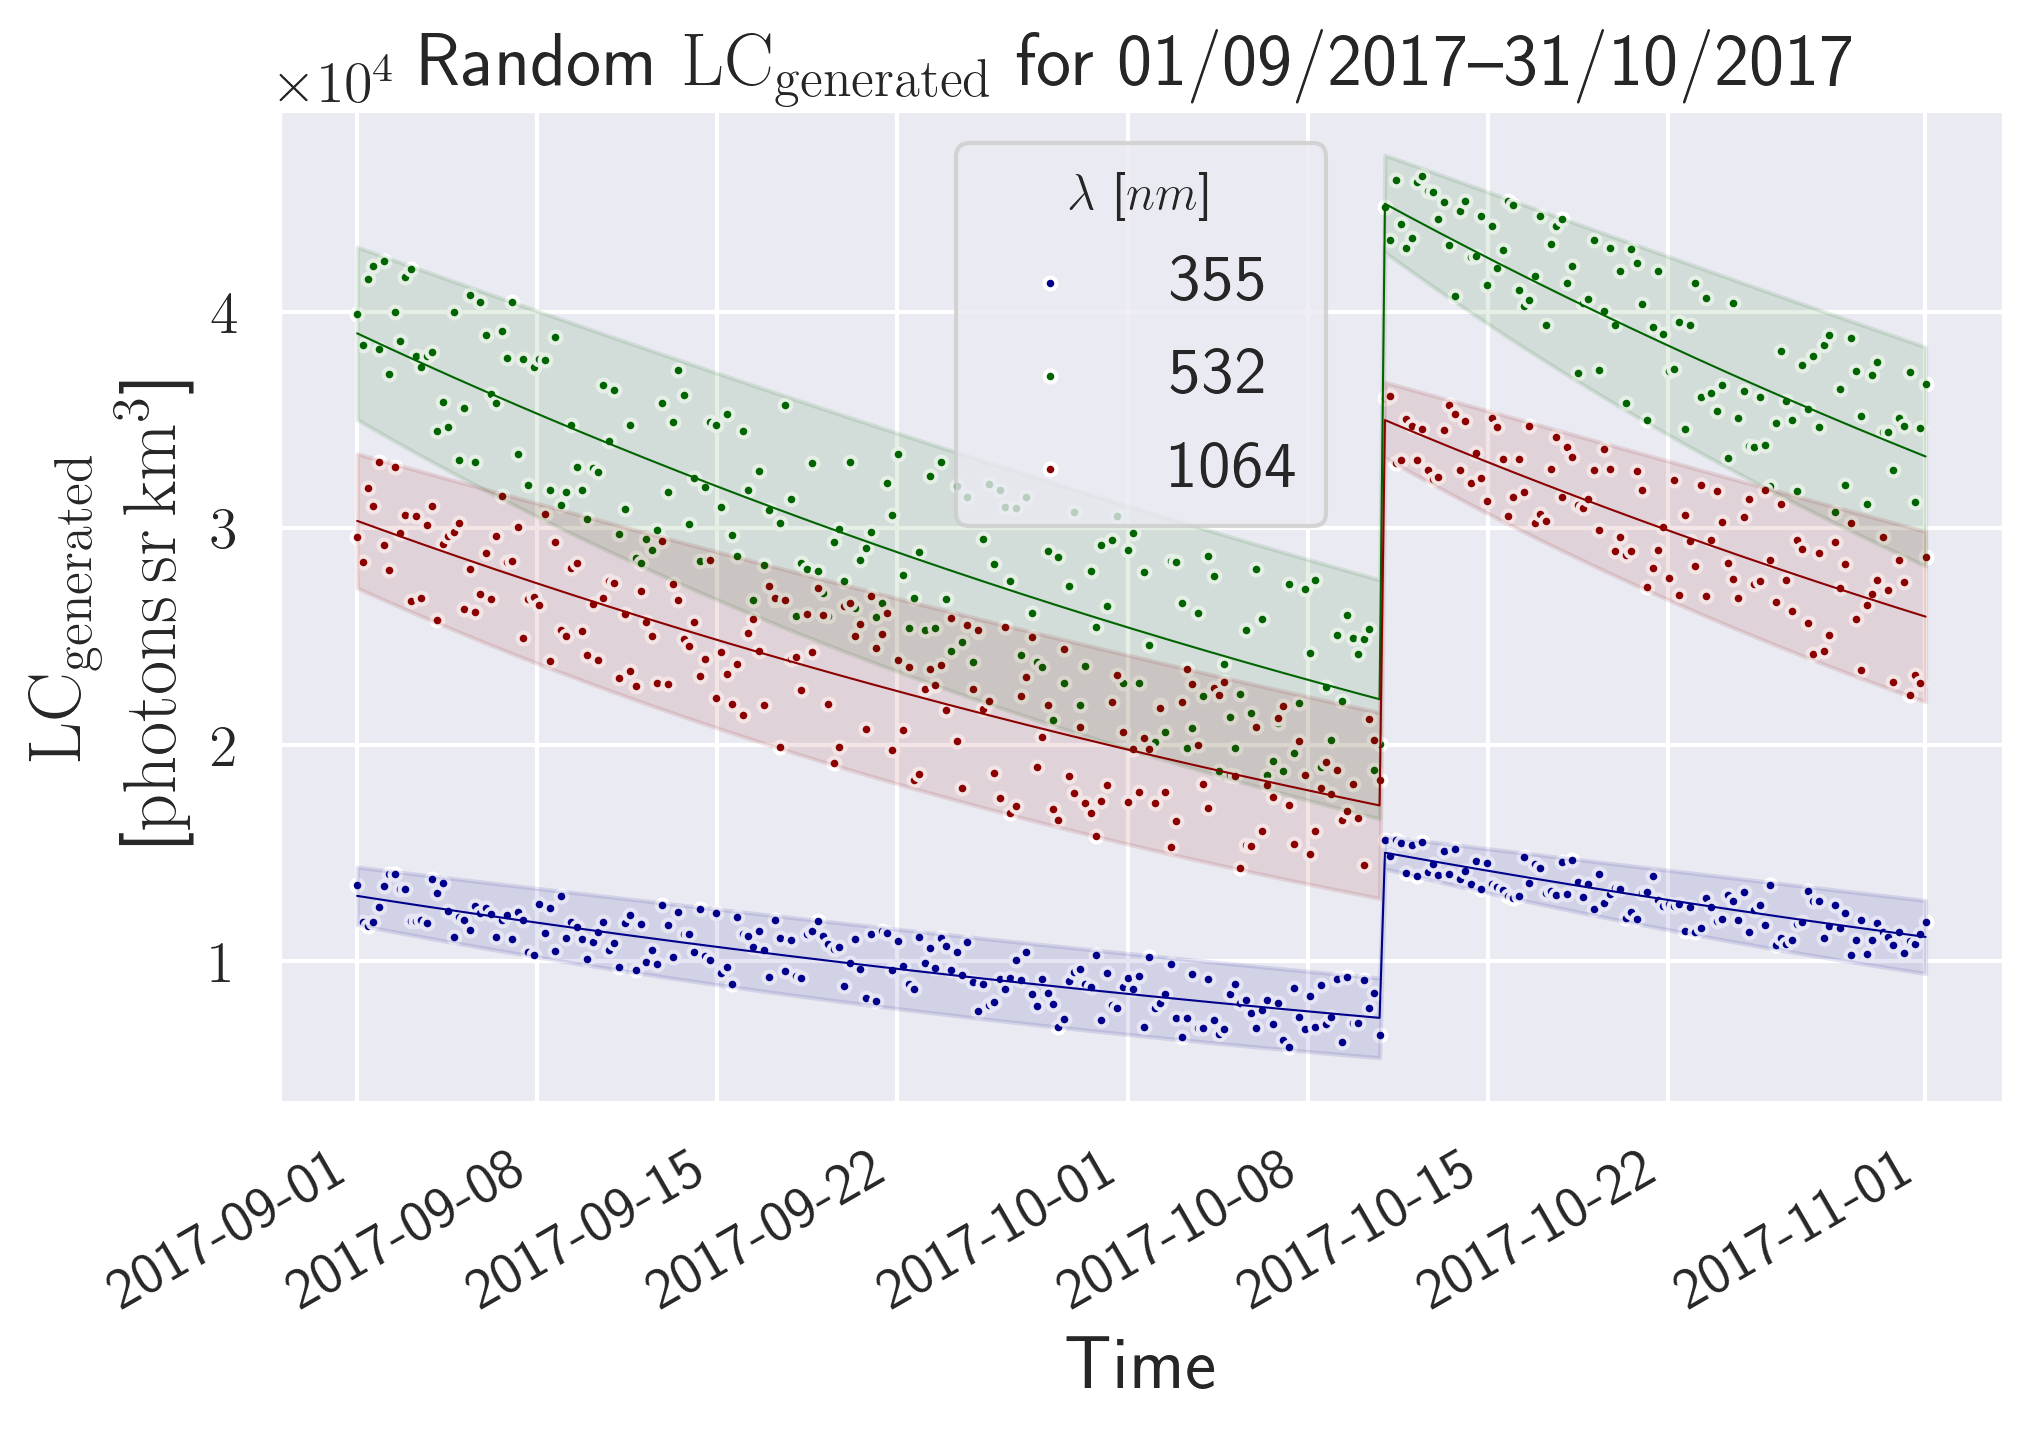

In [8]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(7,5))
ds_gen_p.p.plot(ax=ax,hue='Wavelength',linewidth=0.5)
ds_gen_p.plot.scatter(ax=ax,y='p_new',x='Time',hue='Wavelength',s=8,hue_style ='discrete',edgecolor='w')
for wavelength,c in zip(wavelengths,gs.COLORS):
	ax.fill_between(ds_gen_p.Time.values,
	                 ds_gen_p.p_lbound.sel(Wavelength= wavelength).values,
	                 ds_gen_p.p_ubound.sel(Wavelength=wavelength).values,
	                 color=c, alpha=.1)
ax.set_title(fr"Random {ds_gen_p.p.long_name} for {start_date.strftime('%d/%m/%Y' )}--{end_date.strftime('%d/%m/%Y' )}")
ax.ticklabel_format(axis='y', style="sci",scilimits=(0,0))
plt.tight_layout()
plt.show()

#### 5. Calculate interpolated lidar power per each wavelength for the period from the randomized powers.
- The calculation is based on a fit of randomised powers $p_t, t \in [0,t_{np}]$, with Bezier interpolation.
- The interpolation uses $dn$ bins (points) between each consecutive per of points $p_t, p_{t+1}$.
- $dn$ is set according to lidar measuring frequency of $\delta_t = 30[s]$
- For a period starting at $t_0$, ending at $t_{np}$, there are $np$ randomised points
	-  The total measurements bins will be $n_{total}=\frac {t_1 - t_0 [s]}{\delta_t[s]}$
	-  The amount of interpolated bins between each couple is $dn = \frac{n_{total}}{np-1}$, where $np-1$ is the number of cubic curves to evaluate.

#### 6. Converting Bezier paths to LC(t) and creating dataset of generated lidar power.

In [9]:
# Set the period for calculating bezier fitting
start_time = datetime(2017,9,1)
end_time = final_dt #start_time +timedelta(hours=freq_H)# final_dt# datetime(2017,10,31)
tslice = slice(start_time,end_time)
p_slice = ds_gen_p.p_new.sel(Wavelength=wavelength,Time = tslice)
n_pts = p_slice.Time.size
t0 = p_slice.Time[0].values
t1 = p_slice.Time[-1].values
dt0 = prep.dt64_2_datetime(t0)
dt1 = prep.dt64_2_datetime(t1)
difft = (dt1-dt0)

In [10]:
n_total  = difft.days*station.total_time_bins + difft.seconds/station.freq
dn_t = np.int(n_total/(n_pts-1))
# initialize the points at times of n_pts
points = np.empty((n_pts,2))
points[:,0] = np.array([n*dn_t for n in range(n_pts)])
# Set the time index in which the interpolation is calculated.
power_time_index=pd.date_range(start = start_date, end = final_dt,freq = f'{station.freq}S')
paths_chan=[]
for wavelength in wavelengths:
	points[:,1] = ds_gen_p.p_new.sel(Wavelength=wavelength,Time = tslice).values
	path = Bezier.evaluate_bezier(points, dn_t)
	paths_chan.append(xr.Dataset (
    data_vars = {'p' : (('Time') , path[:,1]) ,
                 'lambda_nm' : ('Wavelength' , np.uint16 ( [ wavelength ] ))
                 } ,
    coords = {'Time' : power_time_index.values ,
              'Wavelength' : np.uint16 ( [ wavelength ] )
                  }))
new_p = xr.concat ( paths_chan , dim = 'Wavelength' )
new_p.p.attrs = {'units' : r'$\rm{photons\,sr\,km^3}$' ,
                 'long_name' : r'$\rm{ LC_{generated}}$' ,
                 'info' : 'LC - Lidar constant - from generation'}
new_p.Wavelength.attrs = {'long_name' : r'$\lambda$','units' :r'$nm$'}

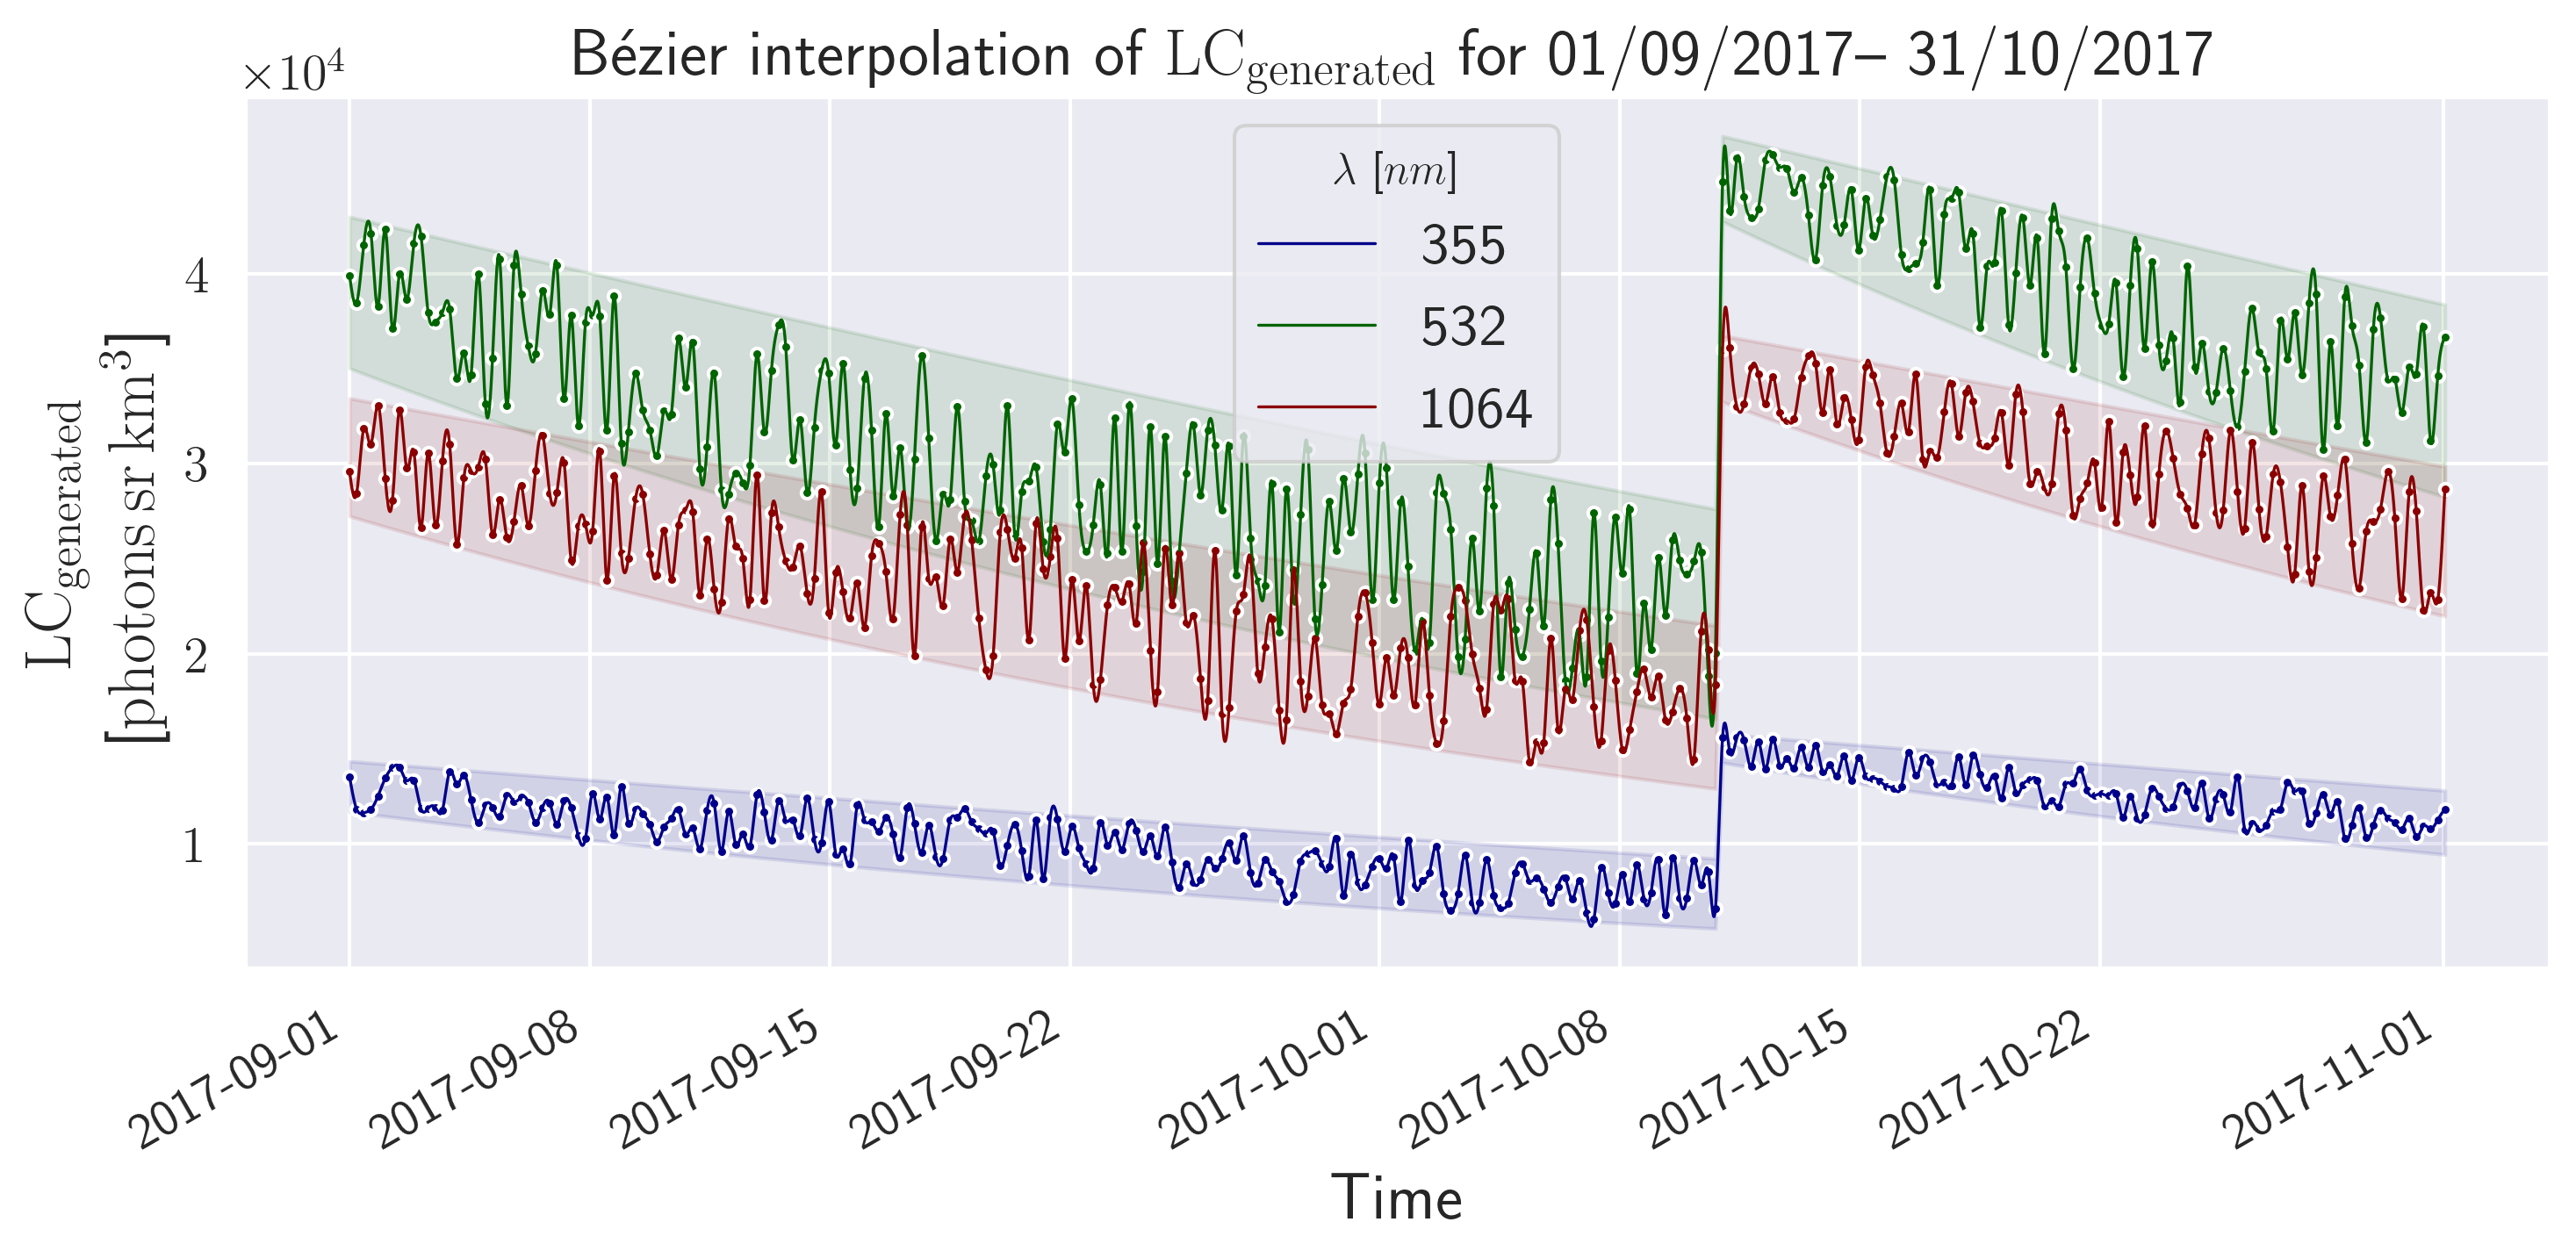

In [11]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(10,5))
for wavelength,c in zip(wavelengths,gs.COLORS):
	ax.fill_between(ds_gen_p.Time.values,
	                 ds_gen_p.p_lbound.sel(Wavelength= wavelength).values,
	                 ds_gen_p.p_ubound.sel(Wavelength=wavelength).values,
	                 color=c, alpha=.1)
ds_gen_p.plot.scatter(ax=ax,y='p_new',x='Time',hue='Wavelength',s=10,hue_style ='discrete',edgecolor='w')
new_p.p.plot(ax=ax,hue='Wavelength',linewidth=0.8)
ax.set_title(fr"B\'ezier interpolation of {new_p.p.long_name} for {start_date.strftime('%d/%m/%Y' )}-- {end_date.strftime('%d/%m/%Y' )}")
ax.ticklabel_format(axis='y', style="sci",scilimits=(0,0))
plt.tight_layout()
plt.show()

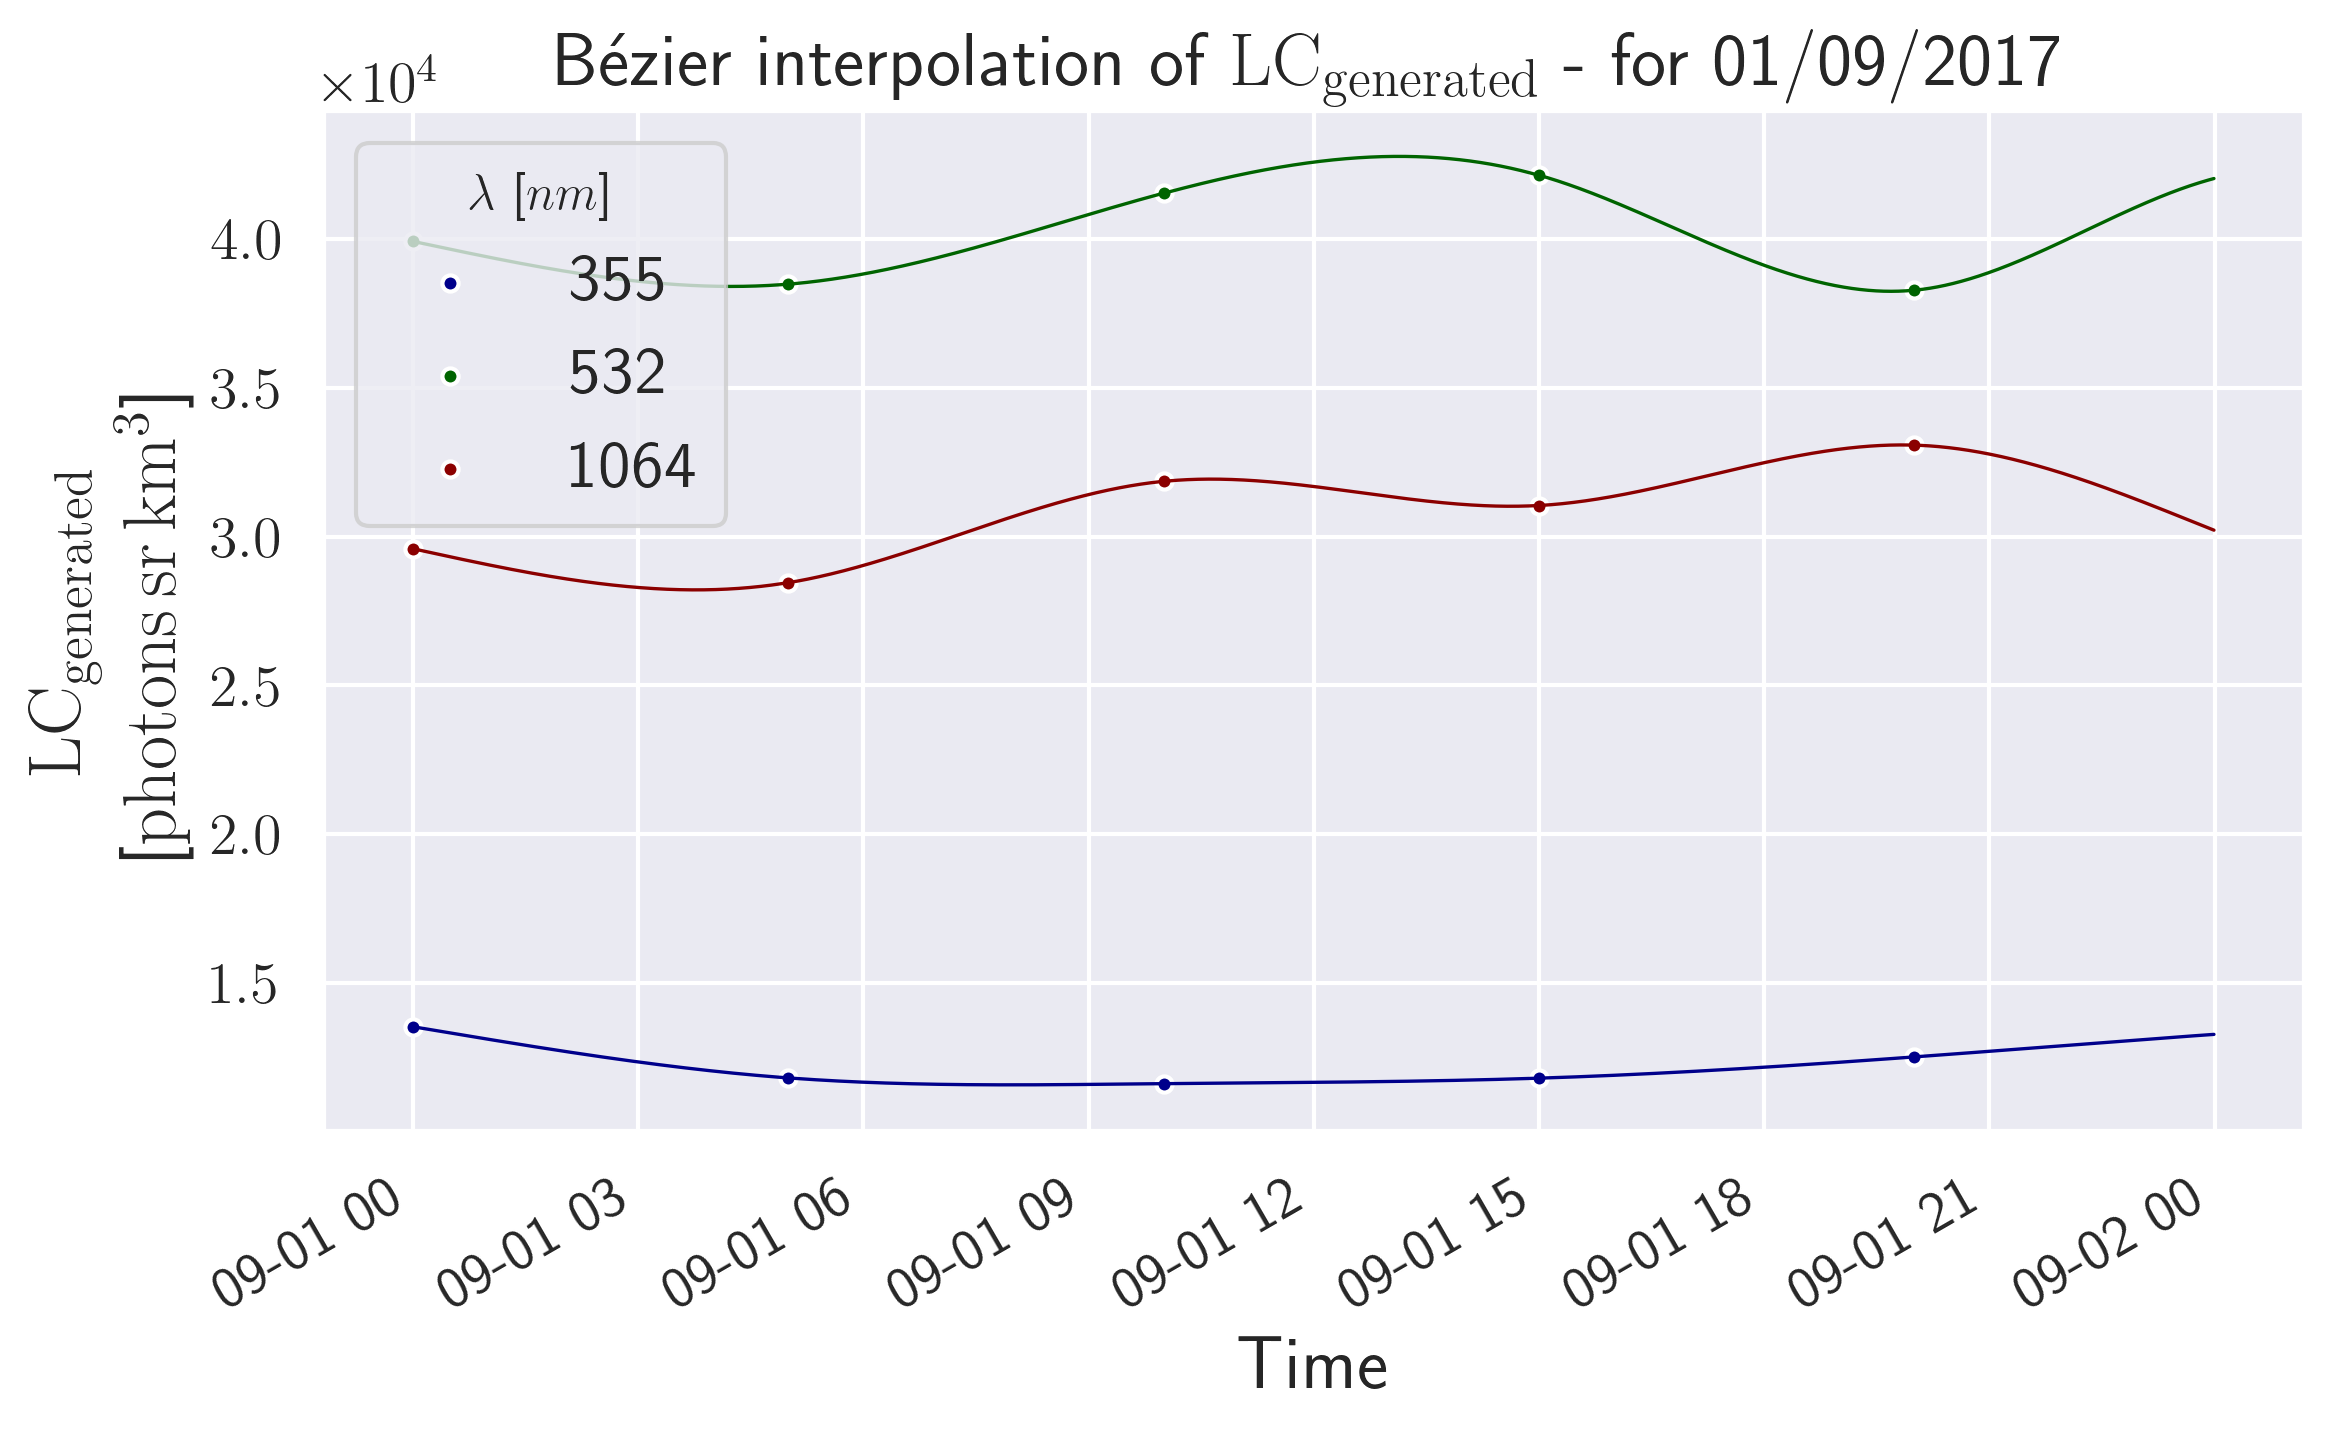

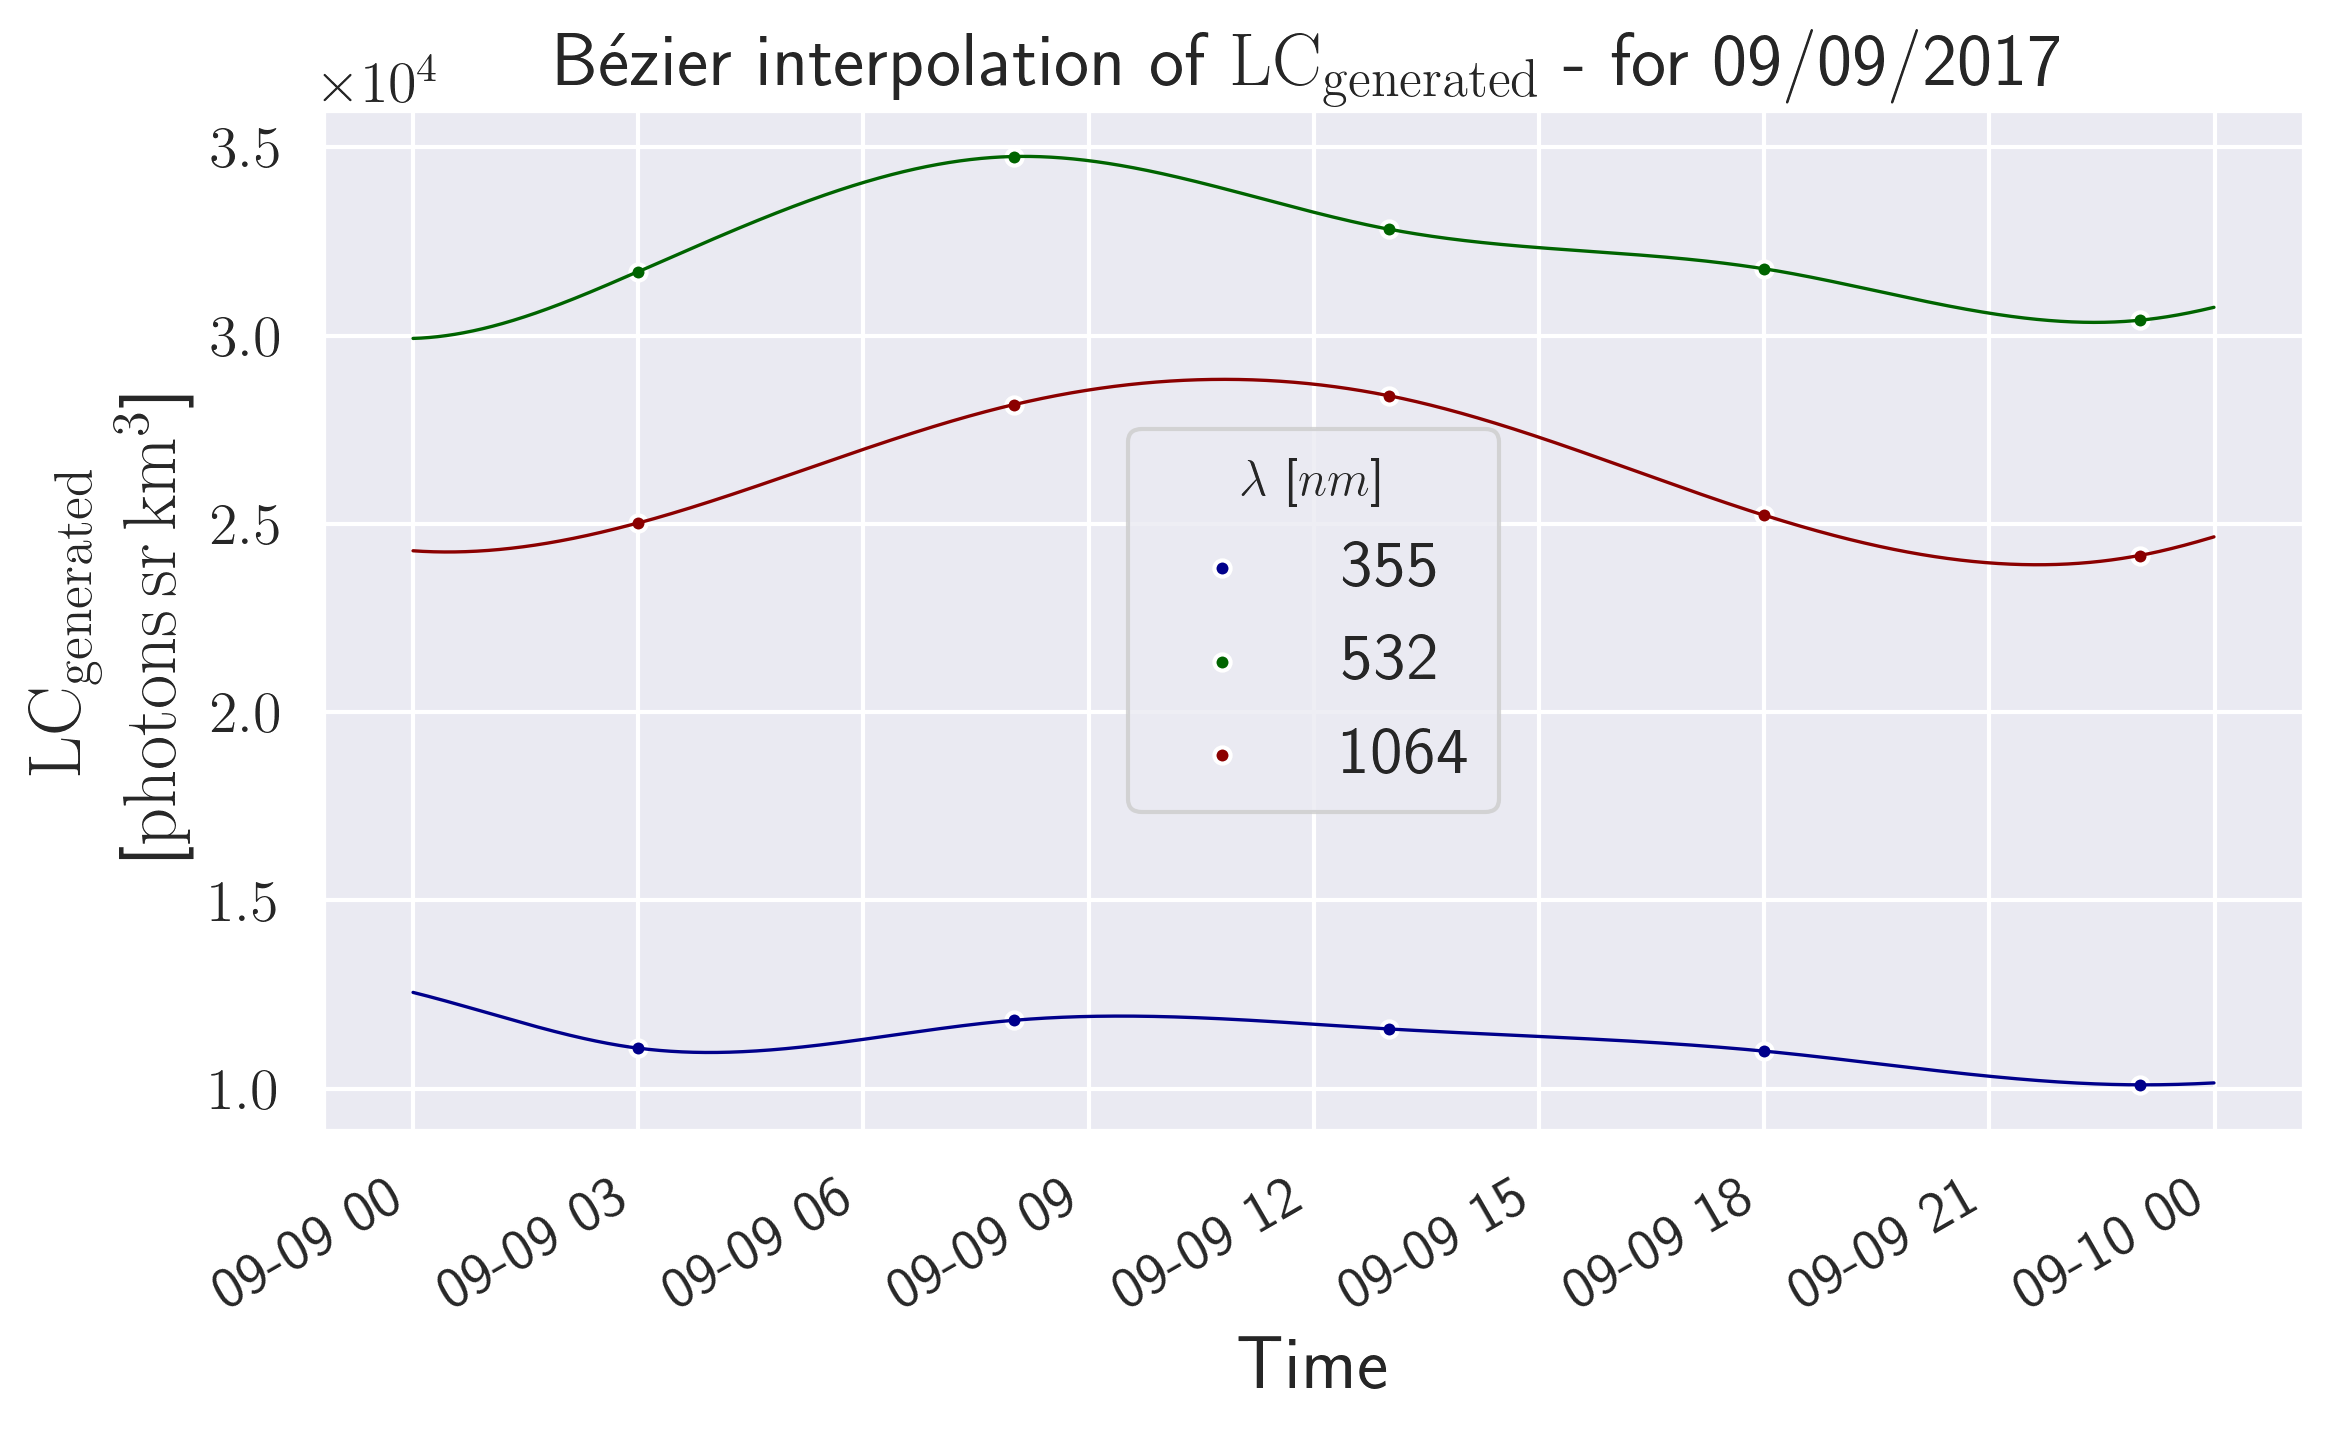

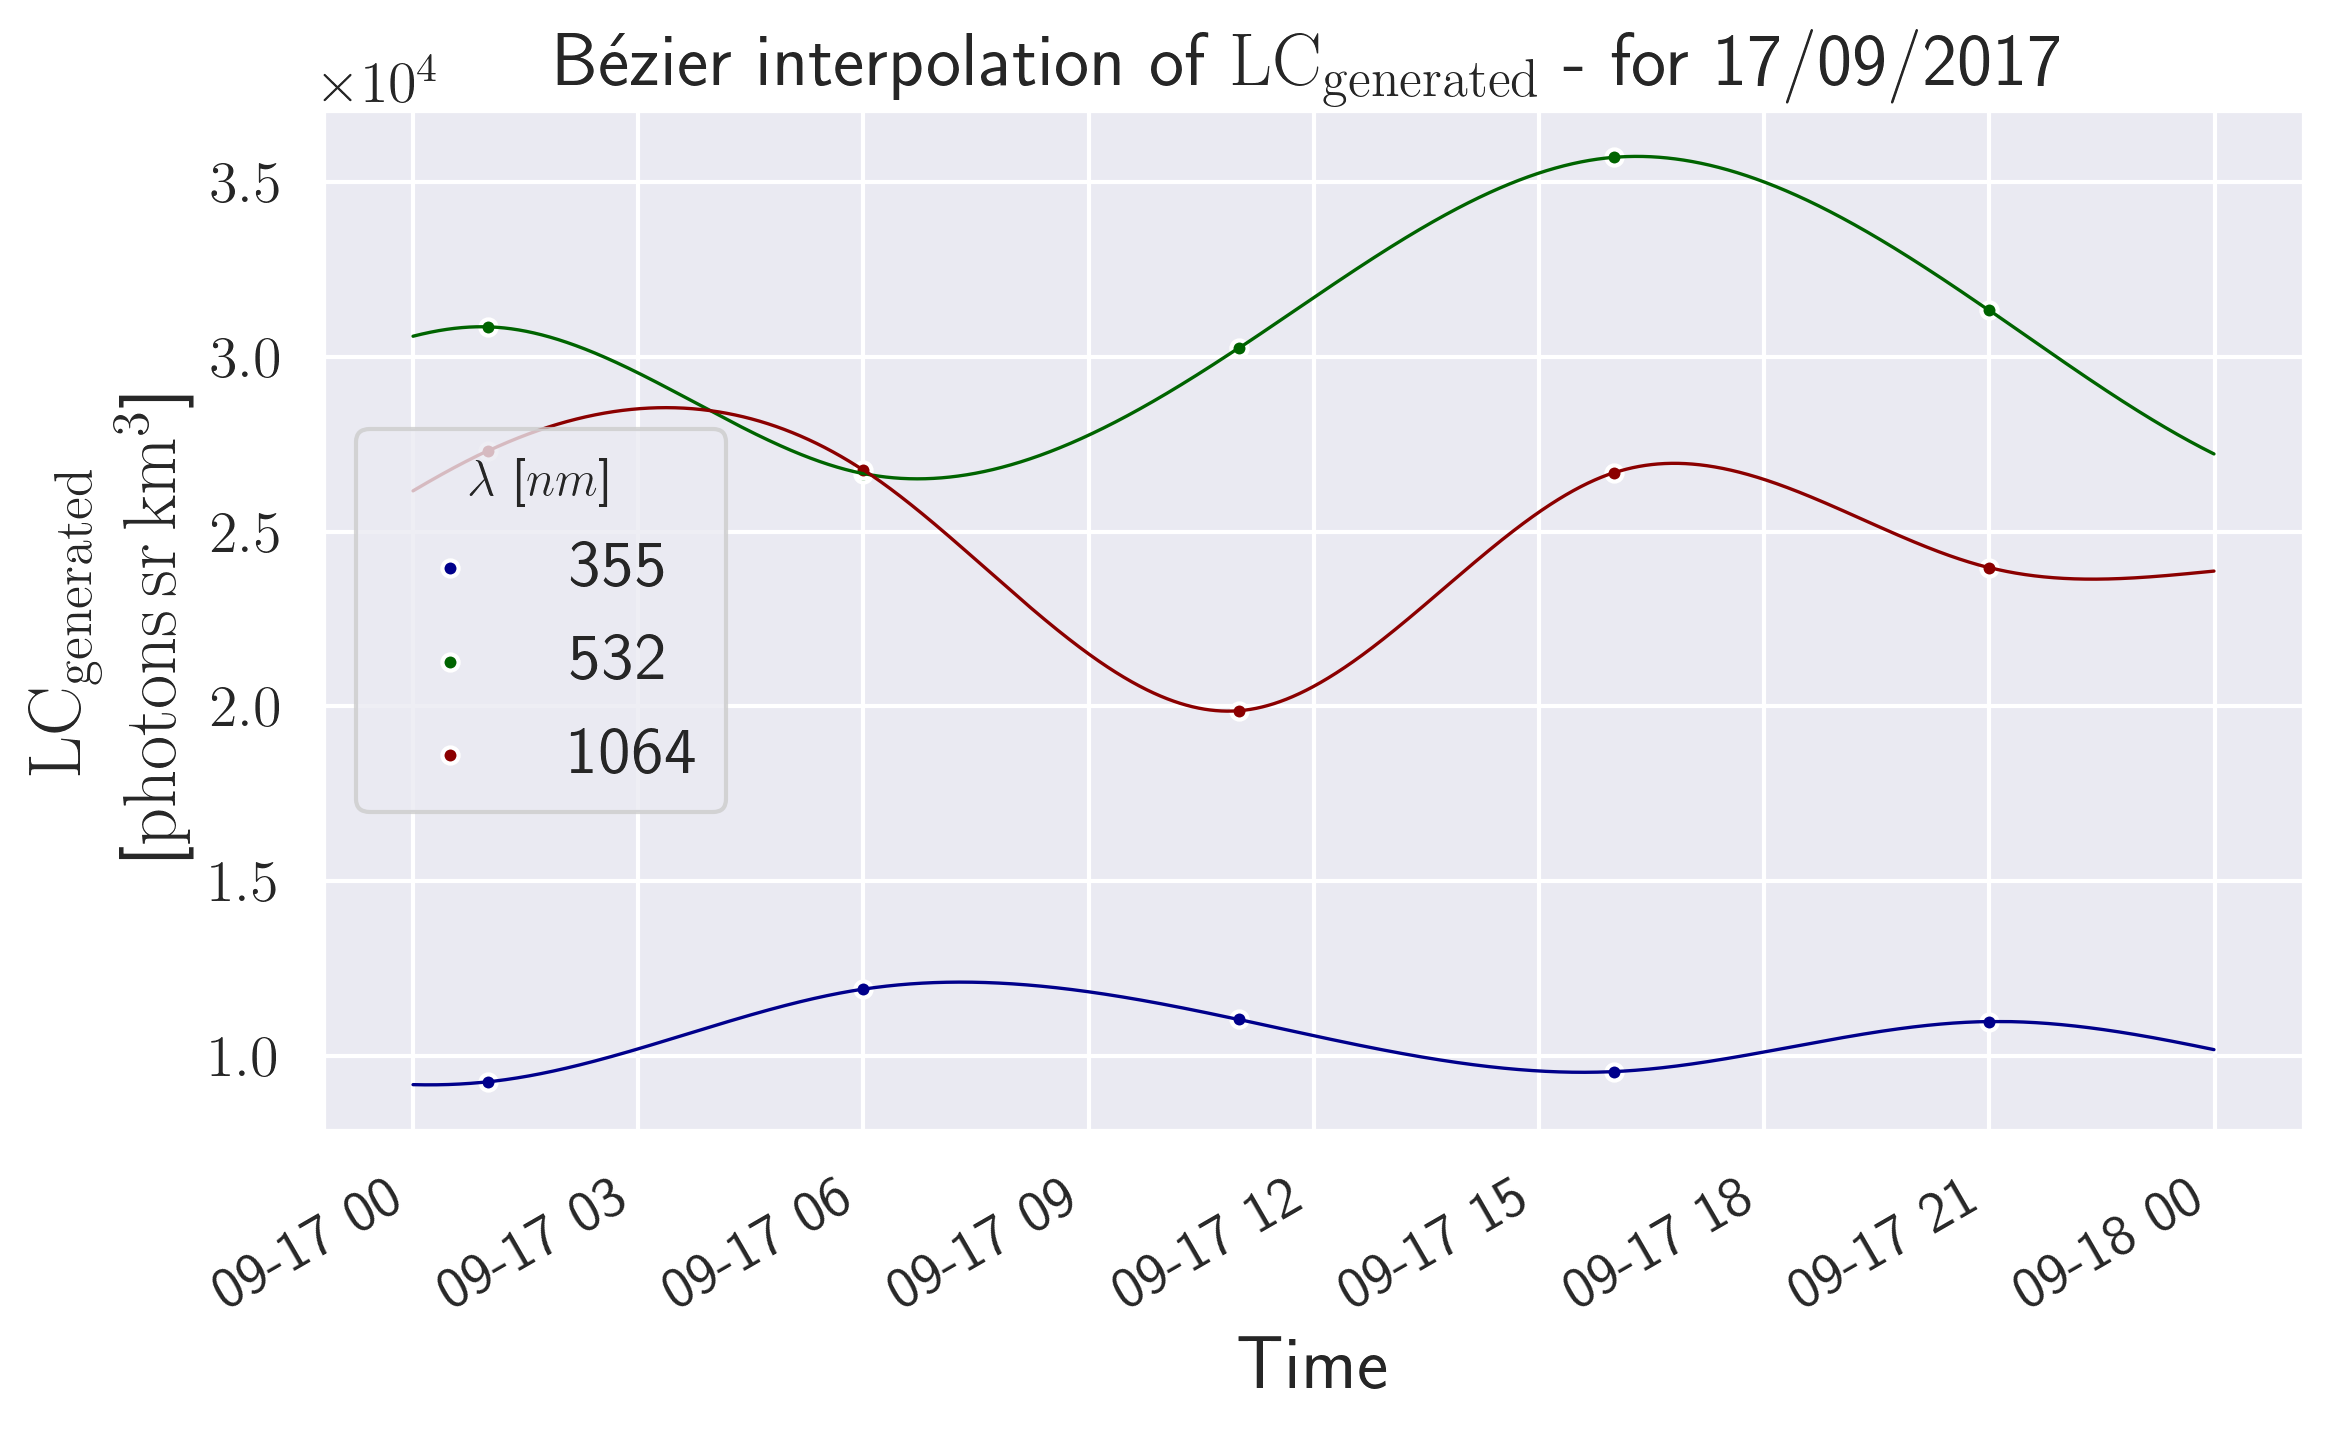

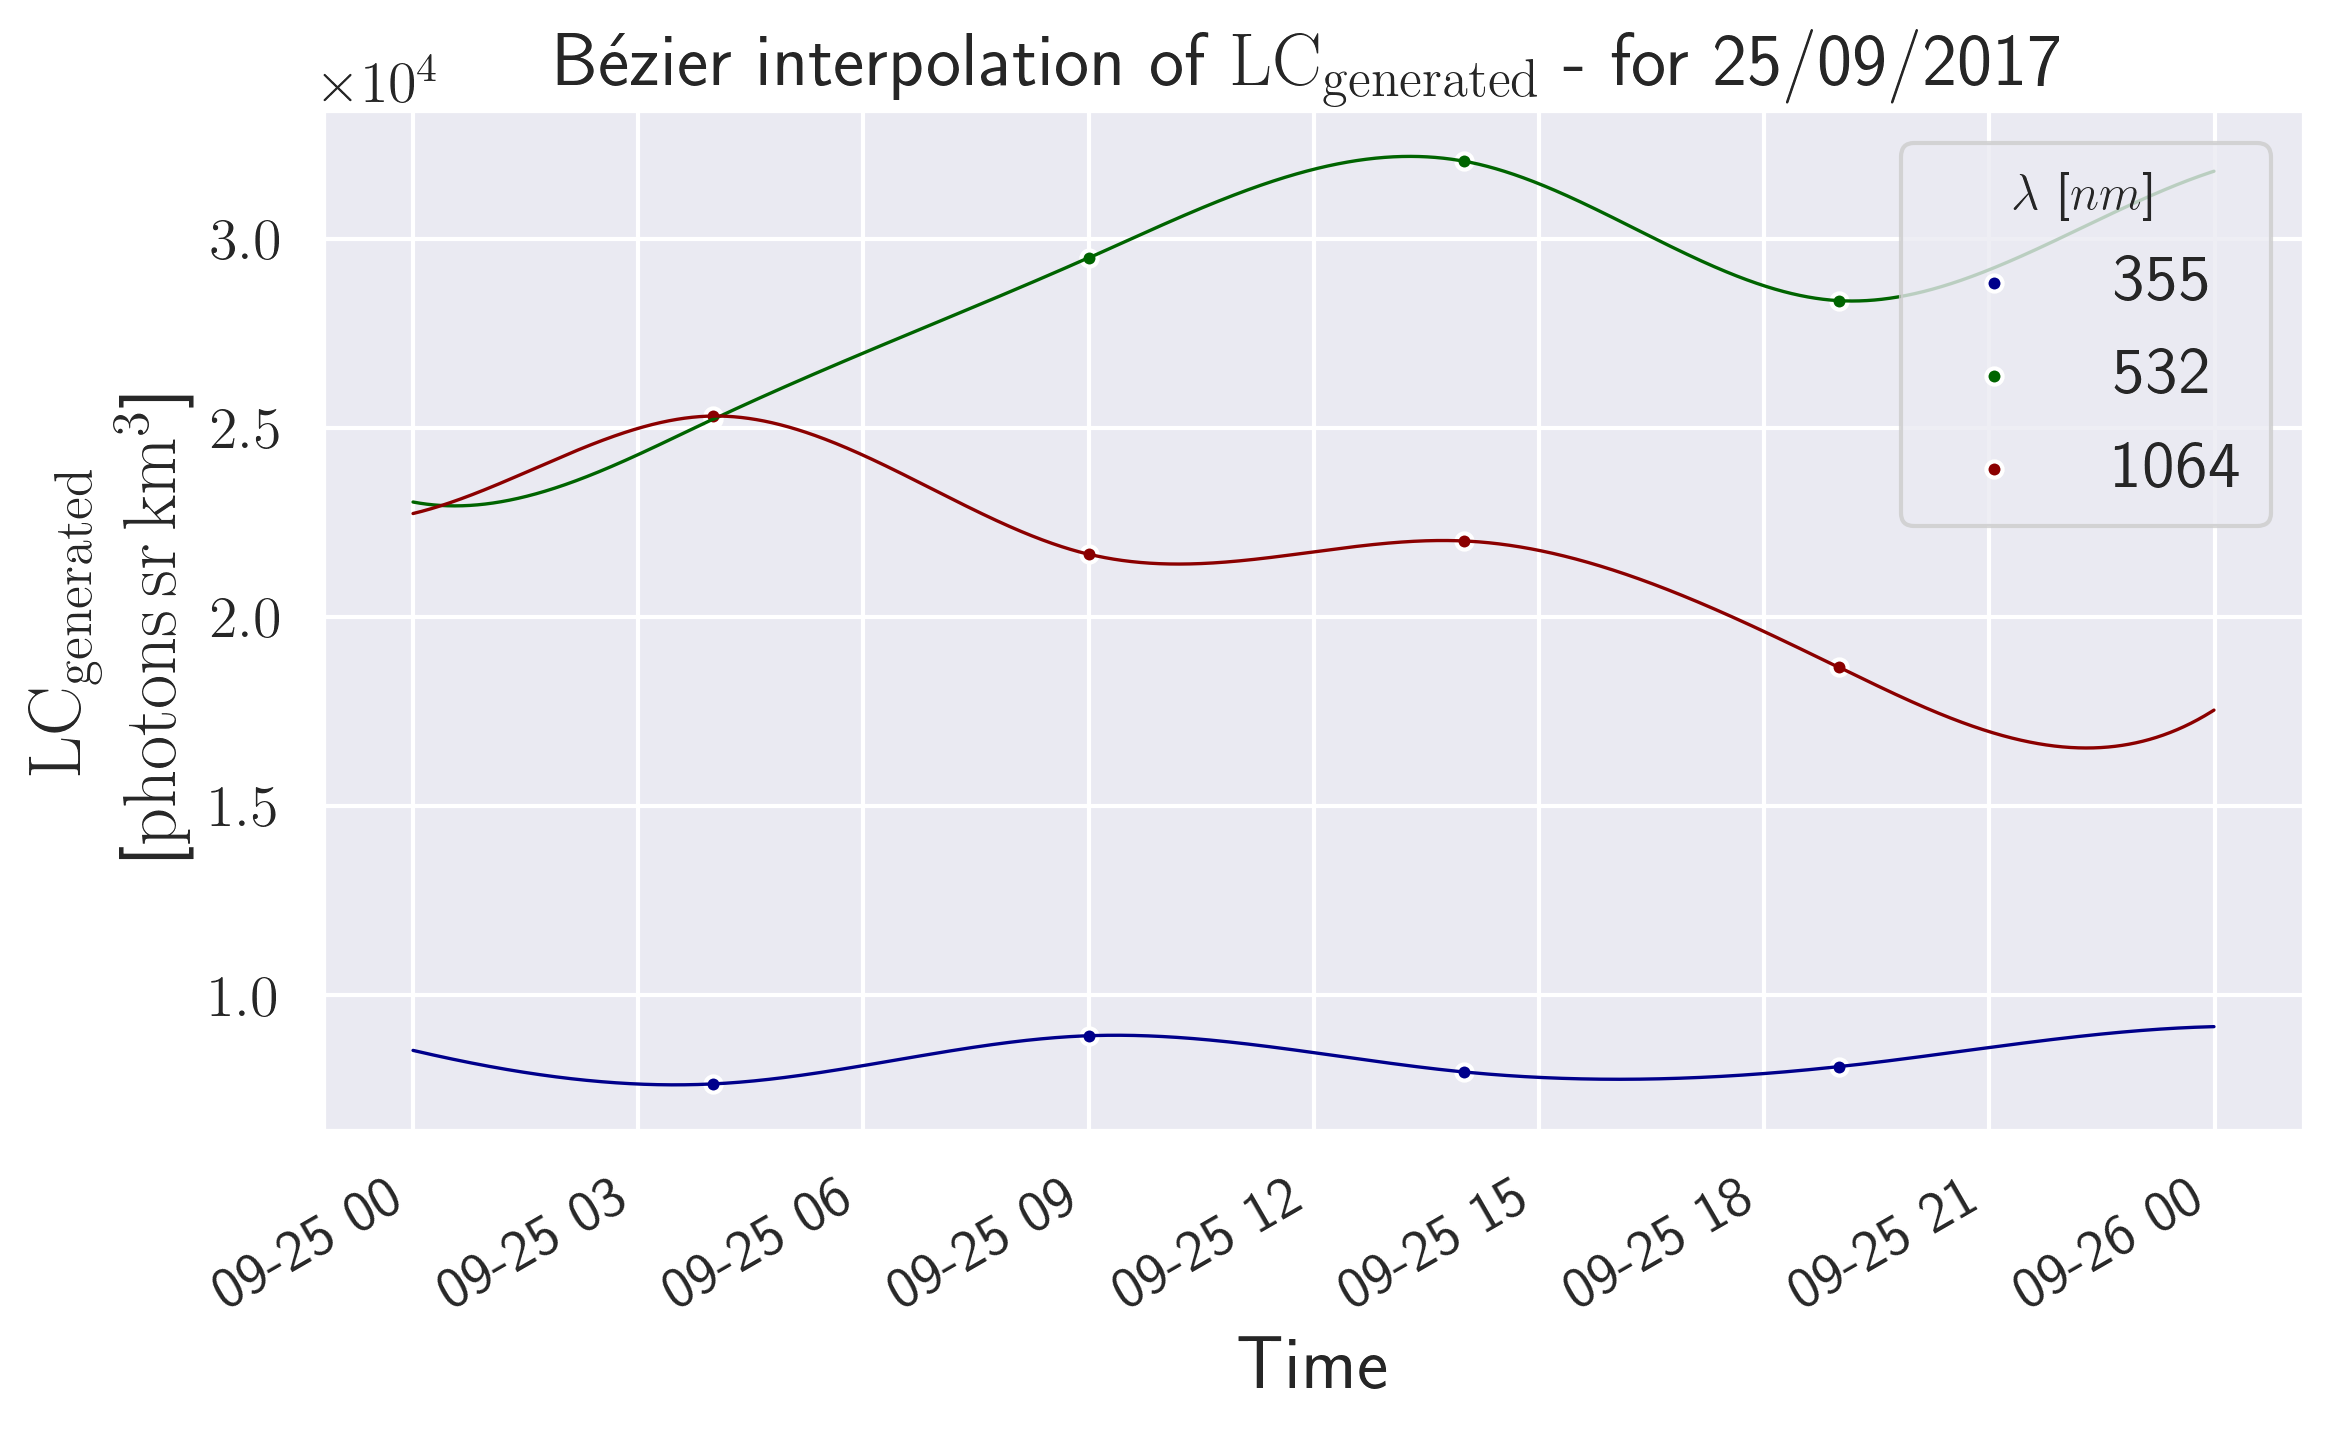

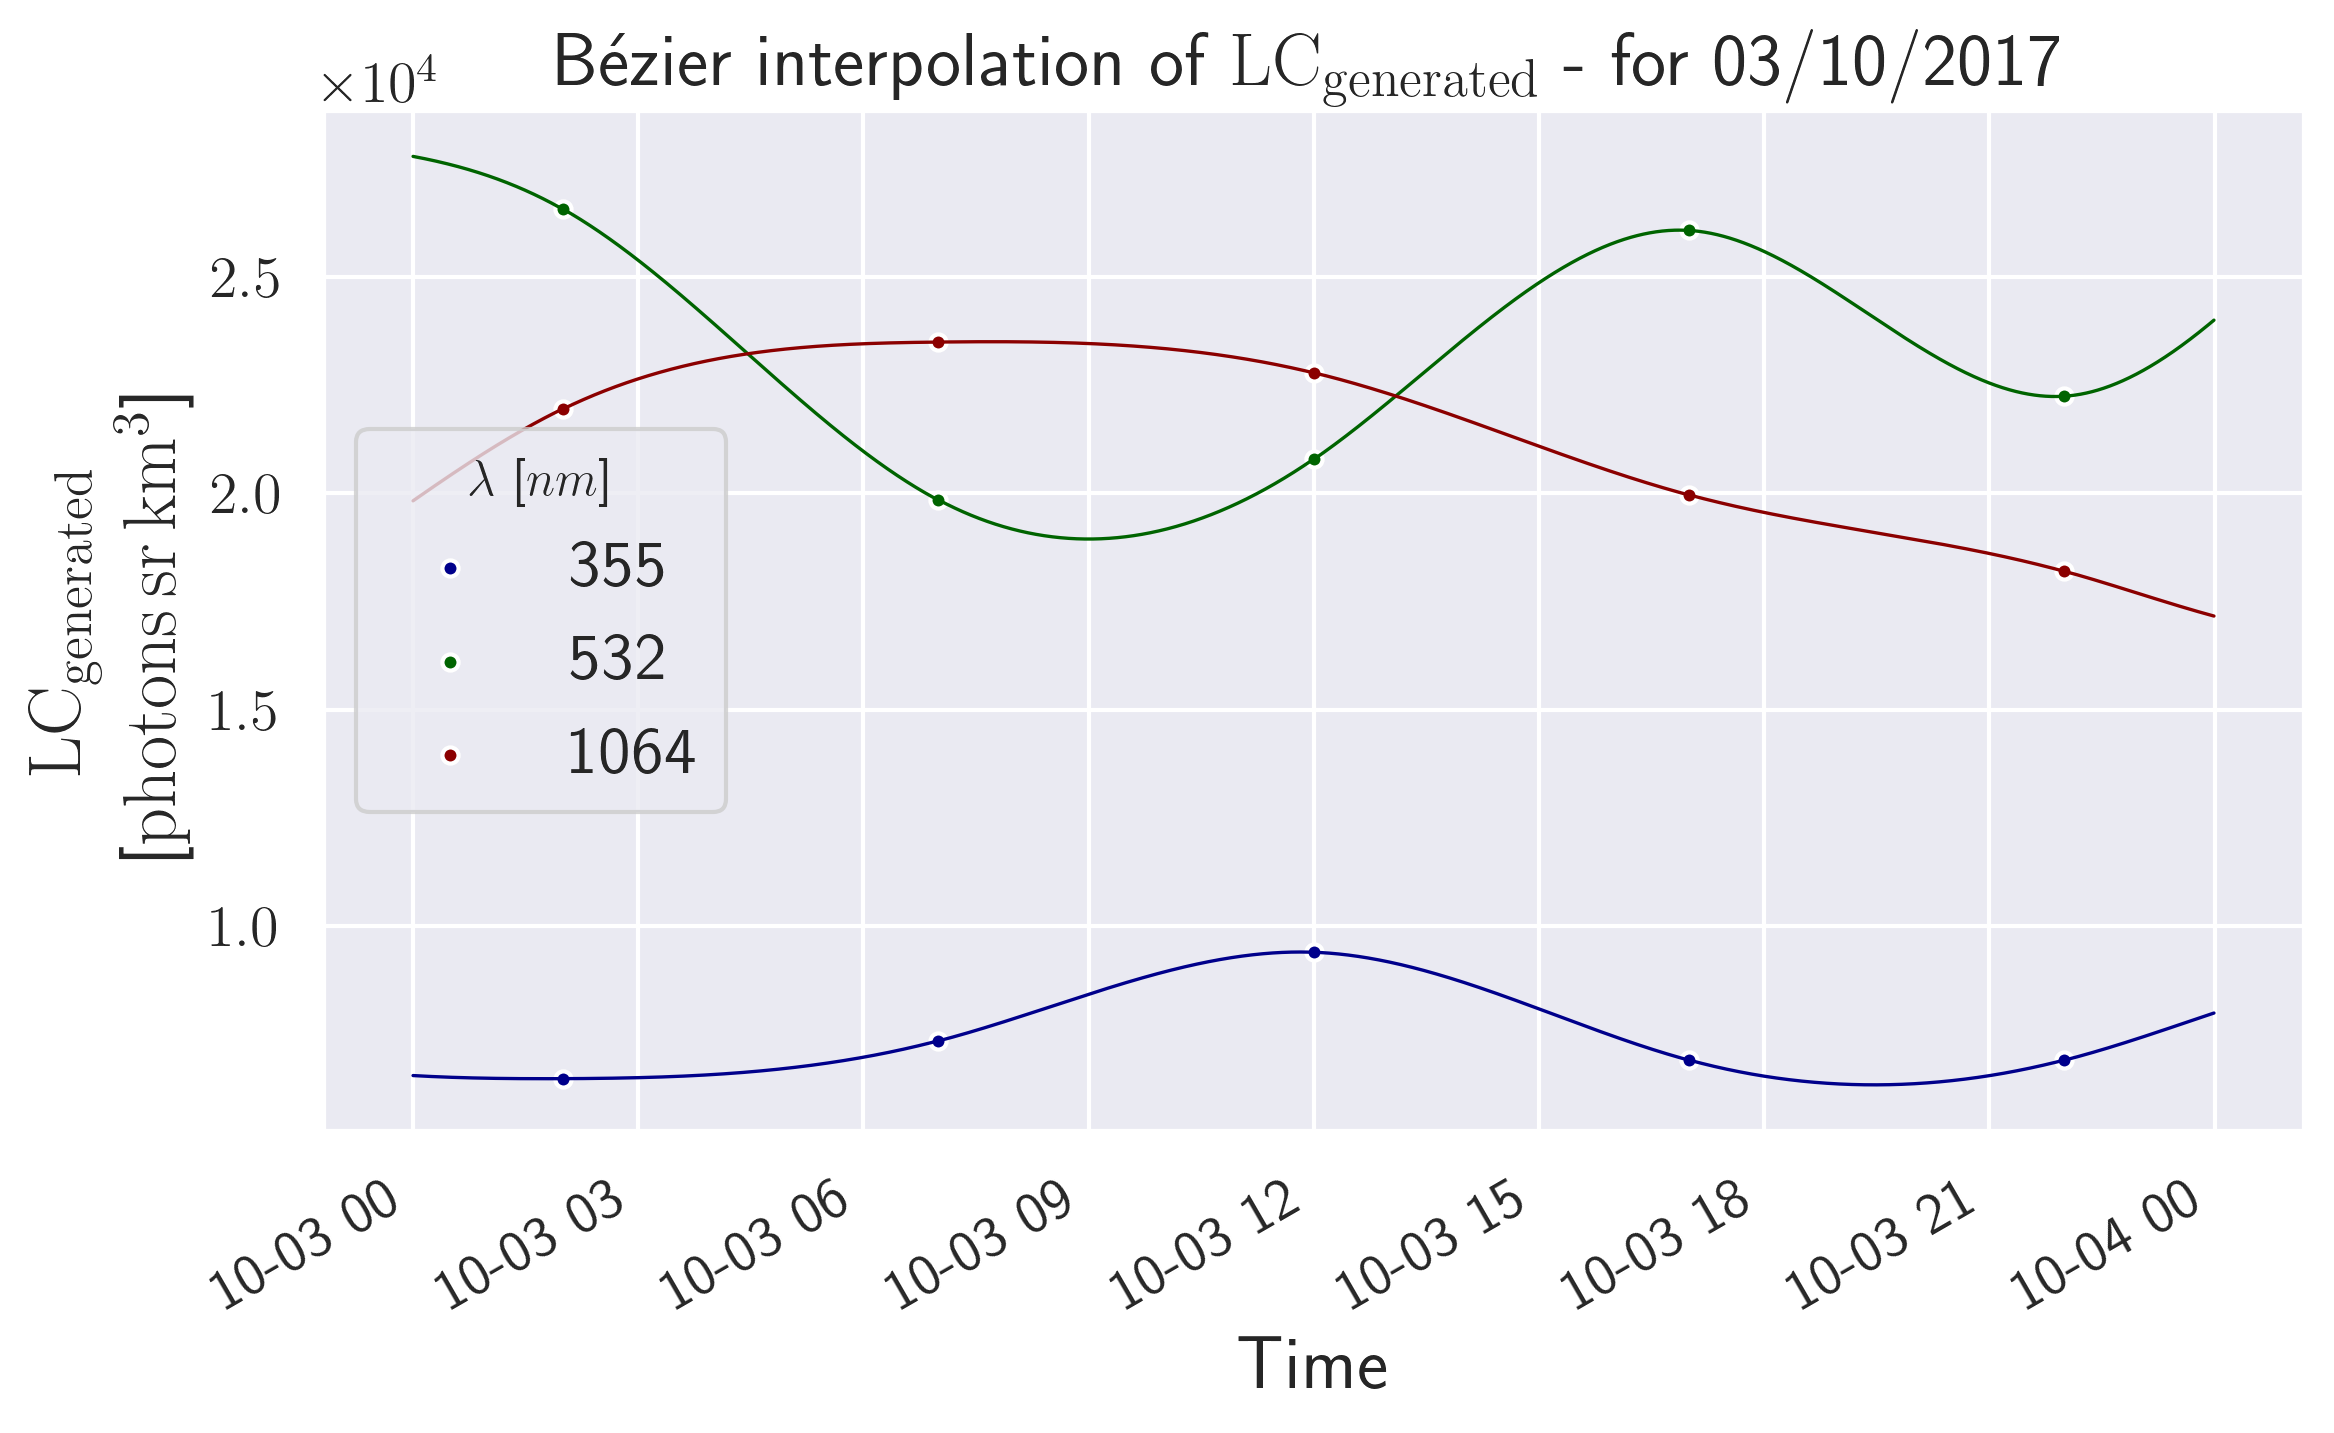

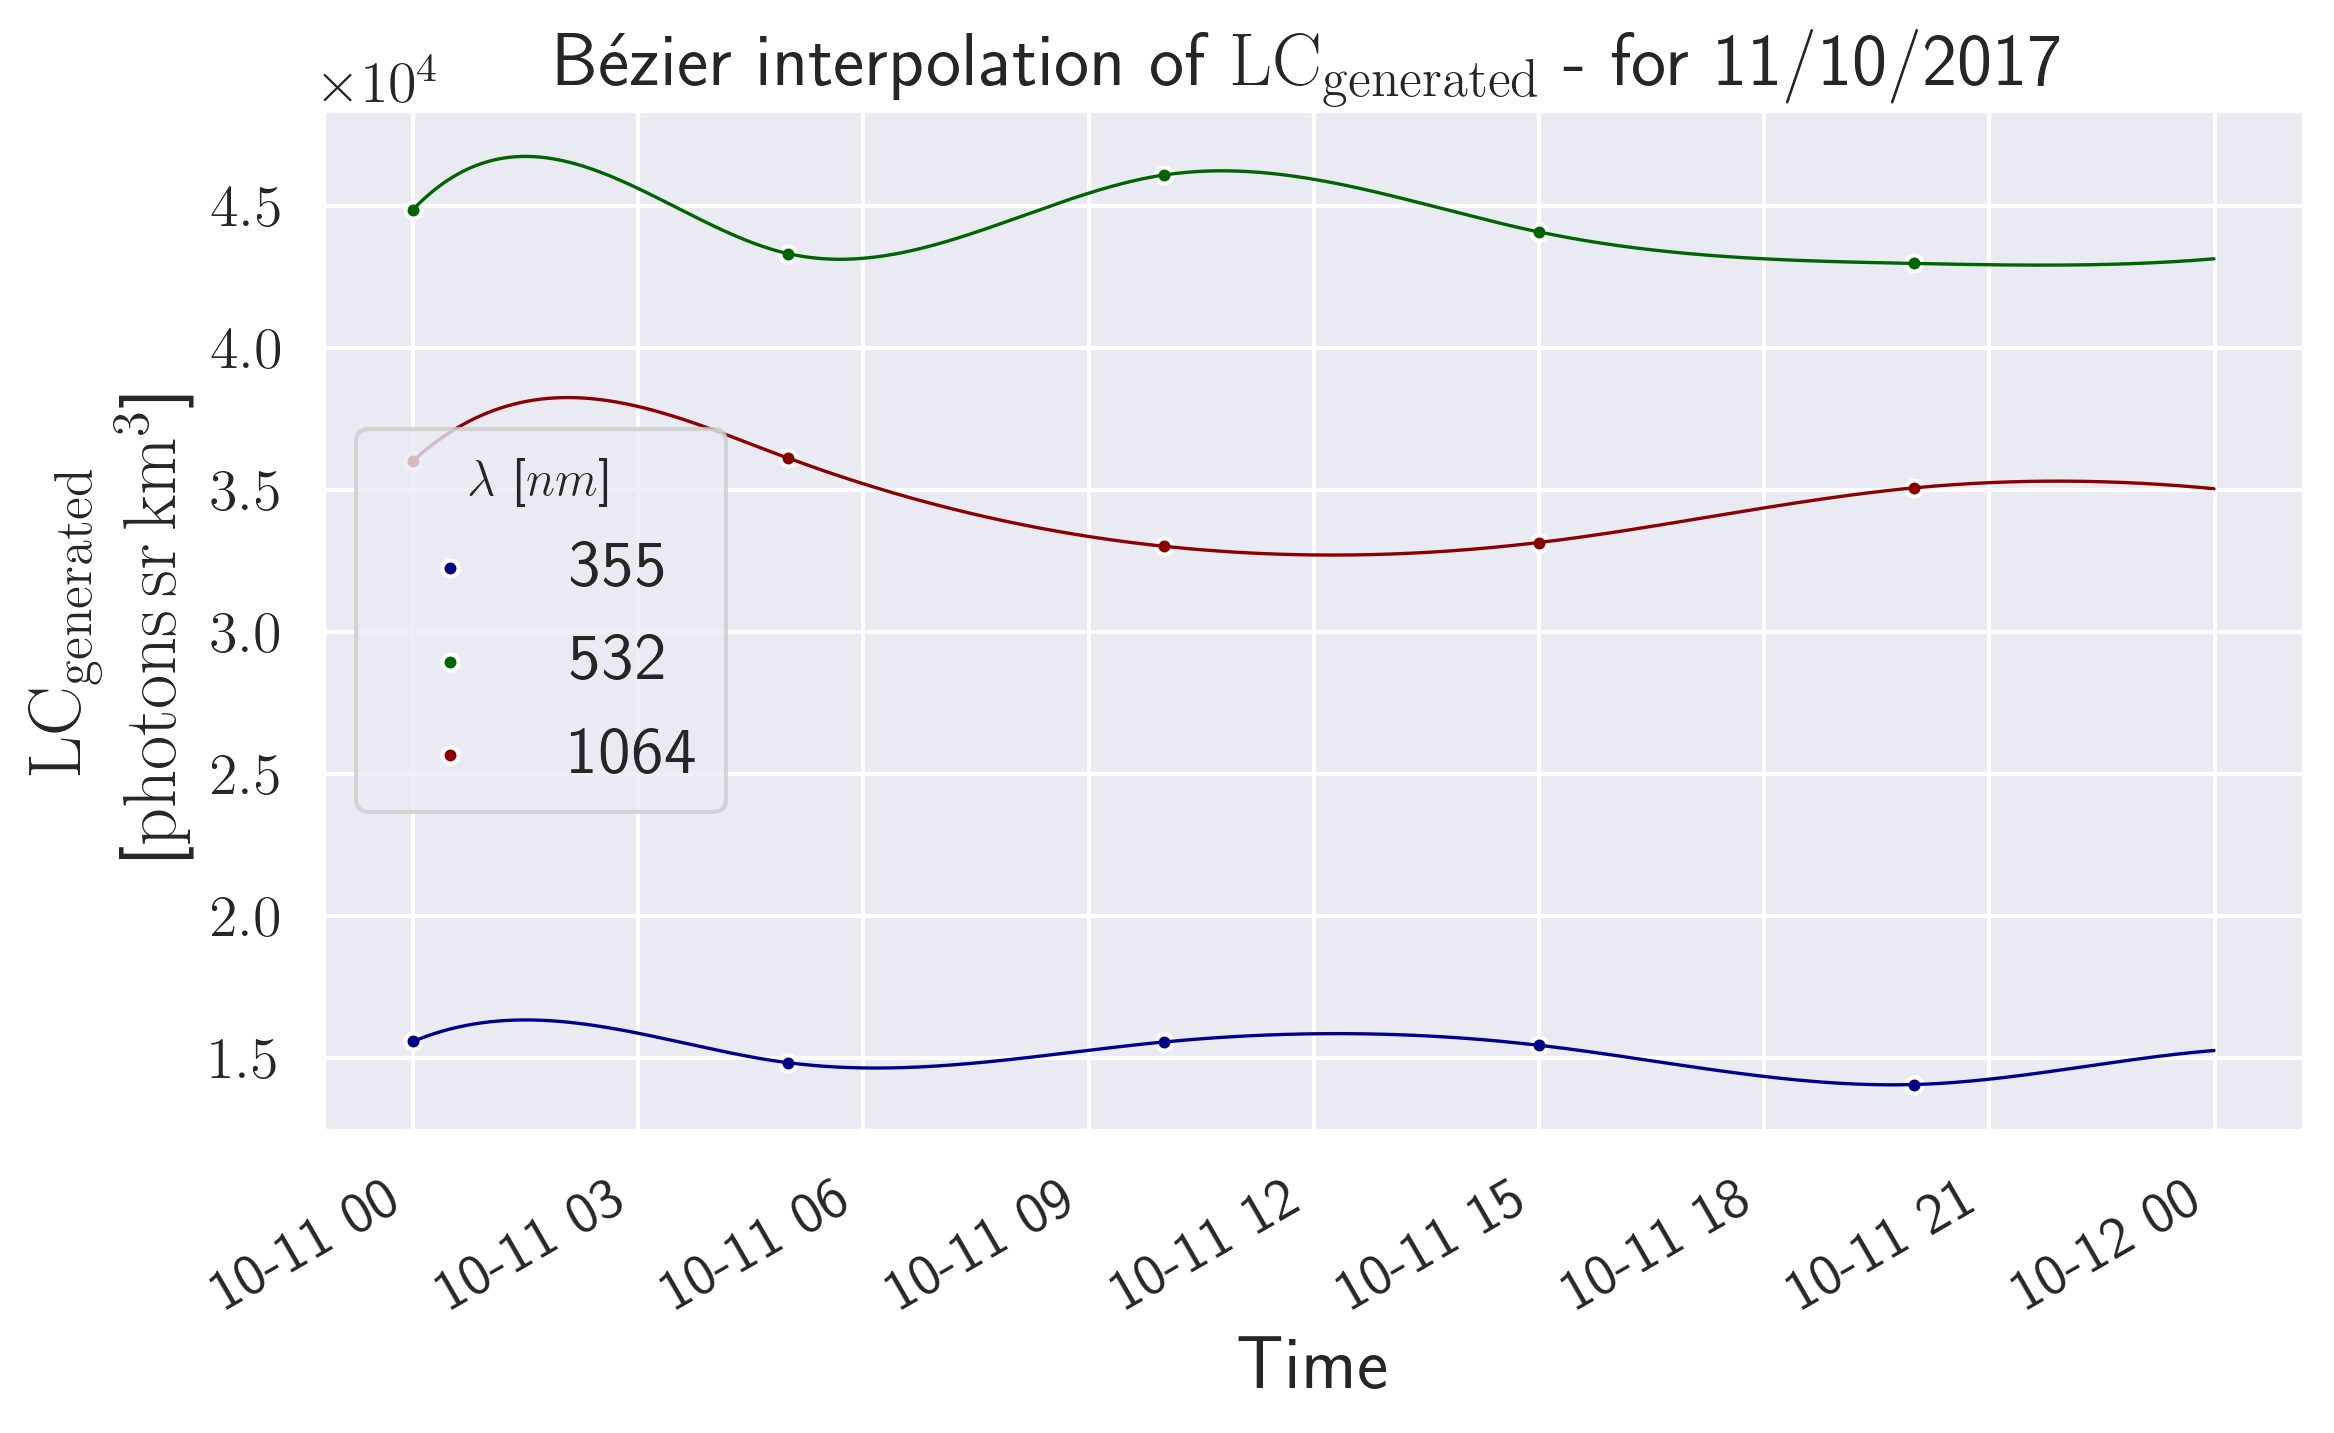

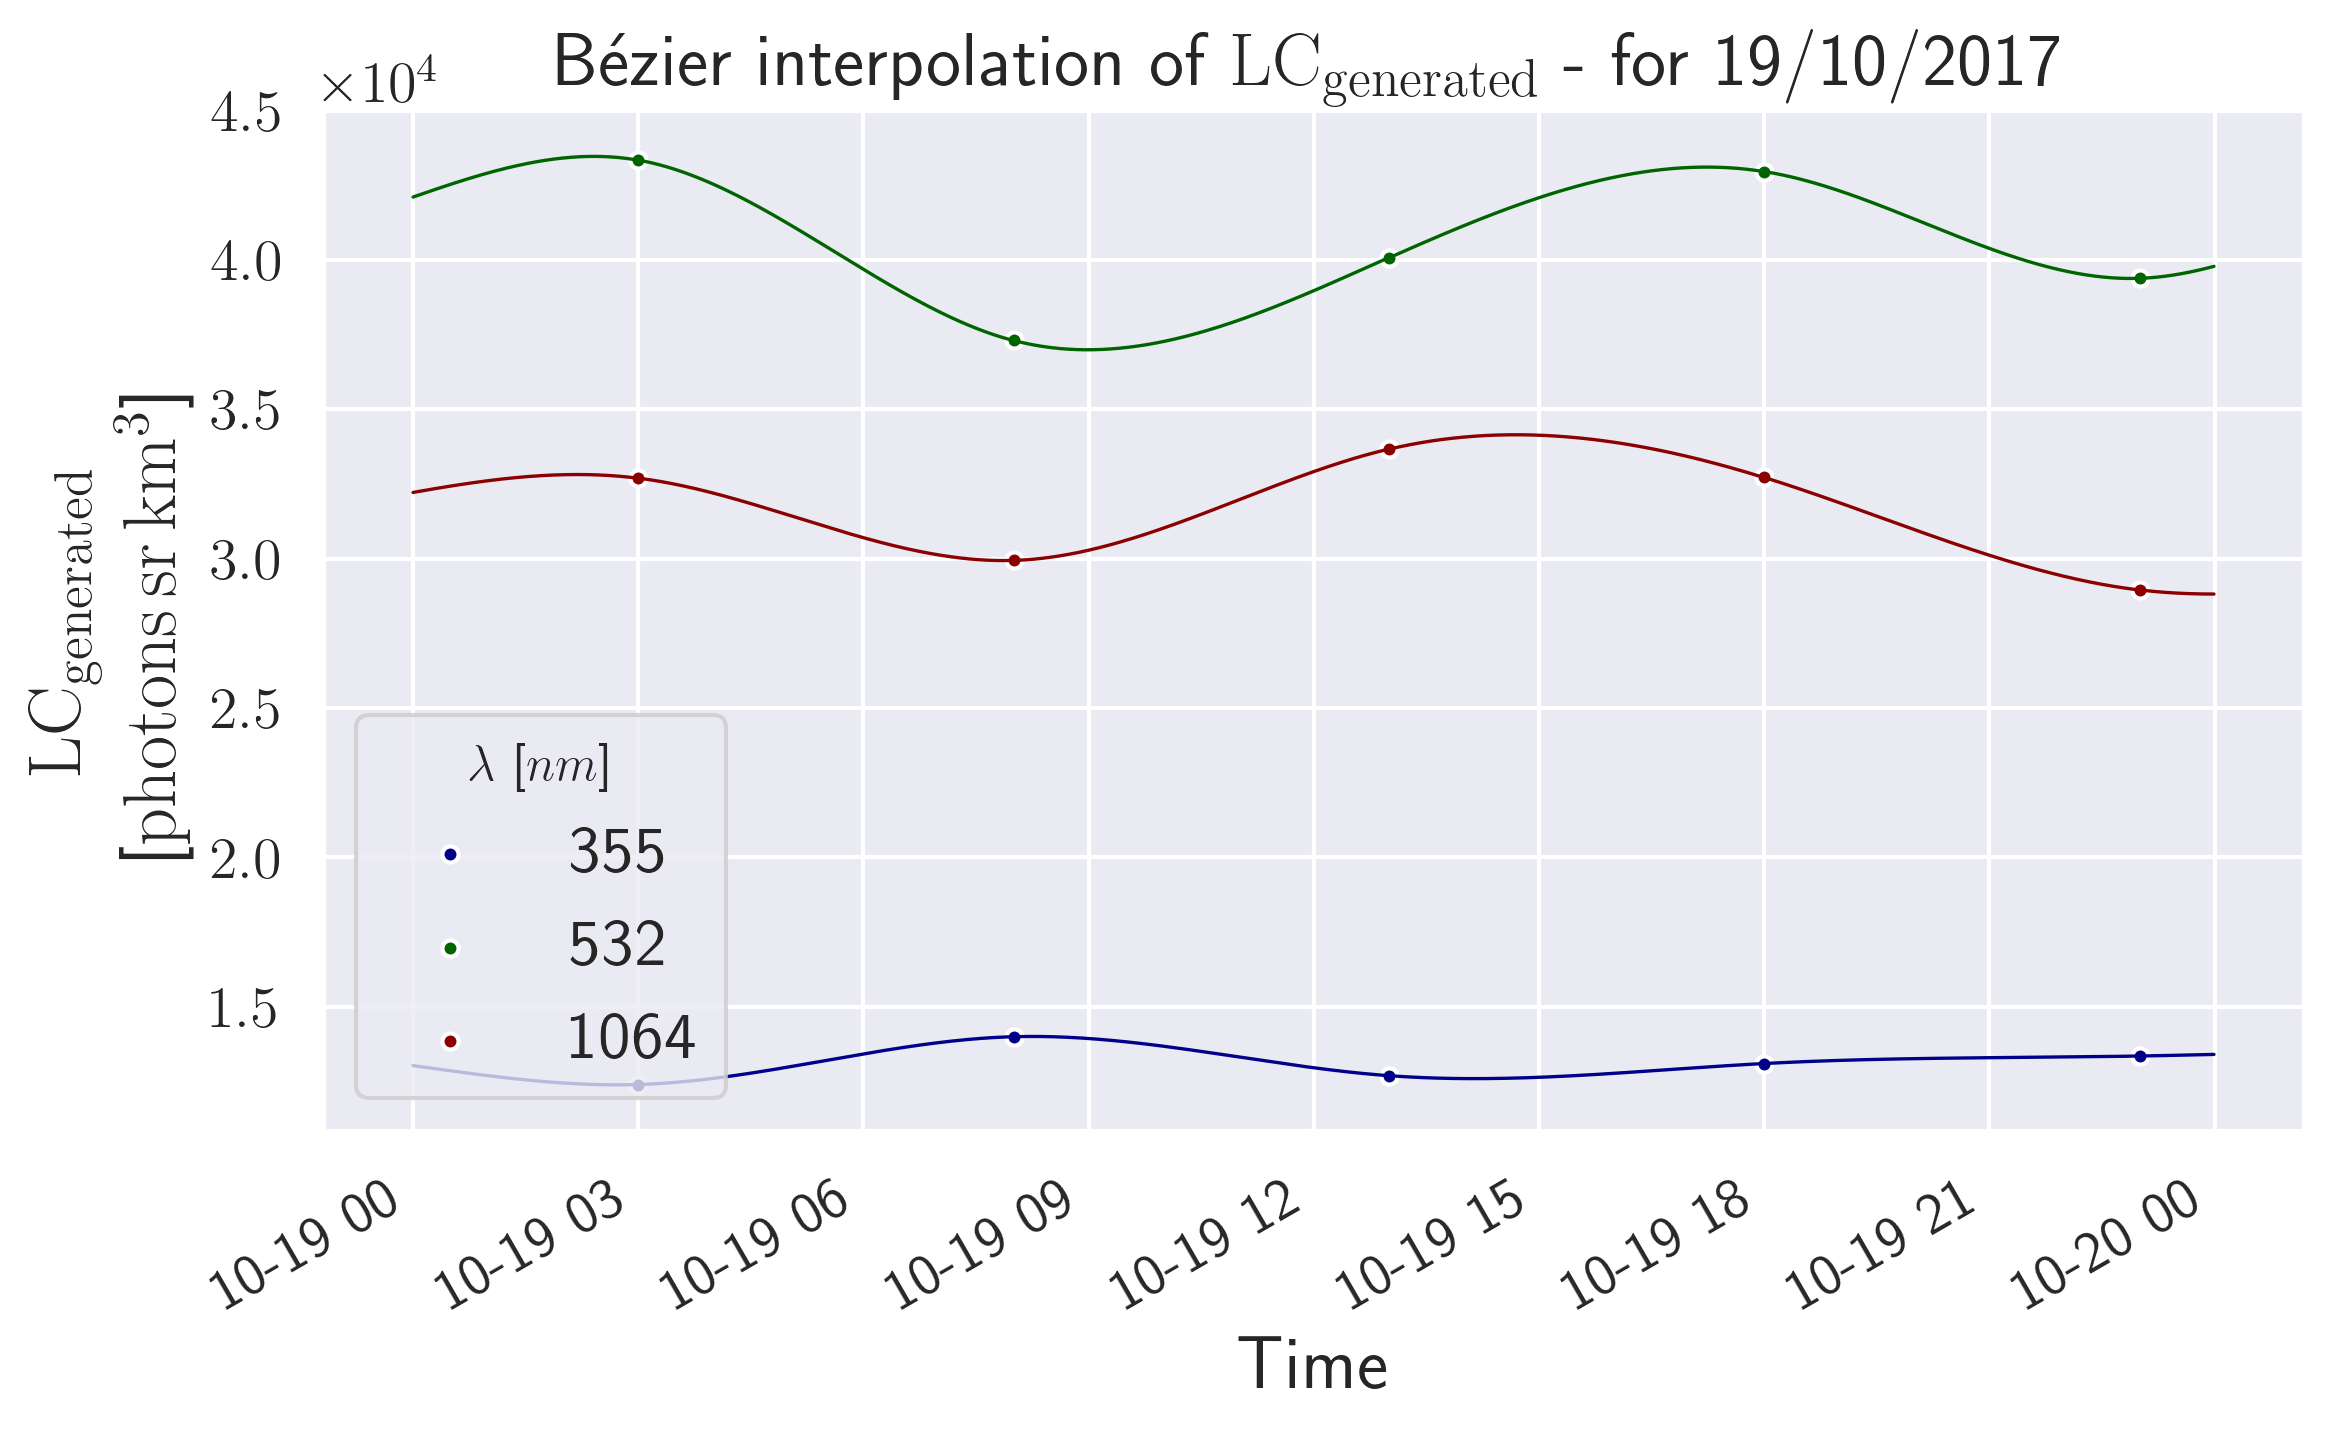

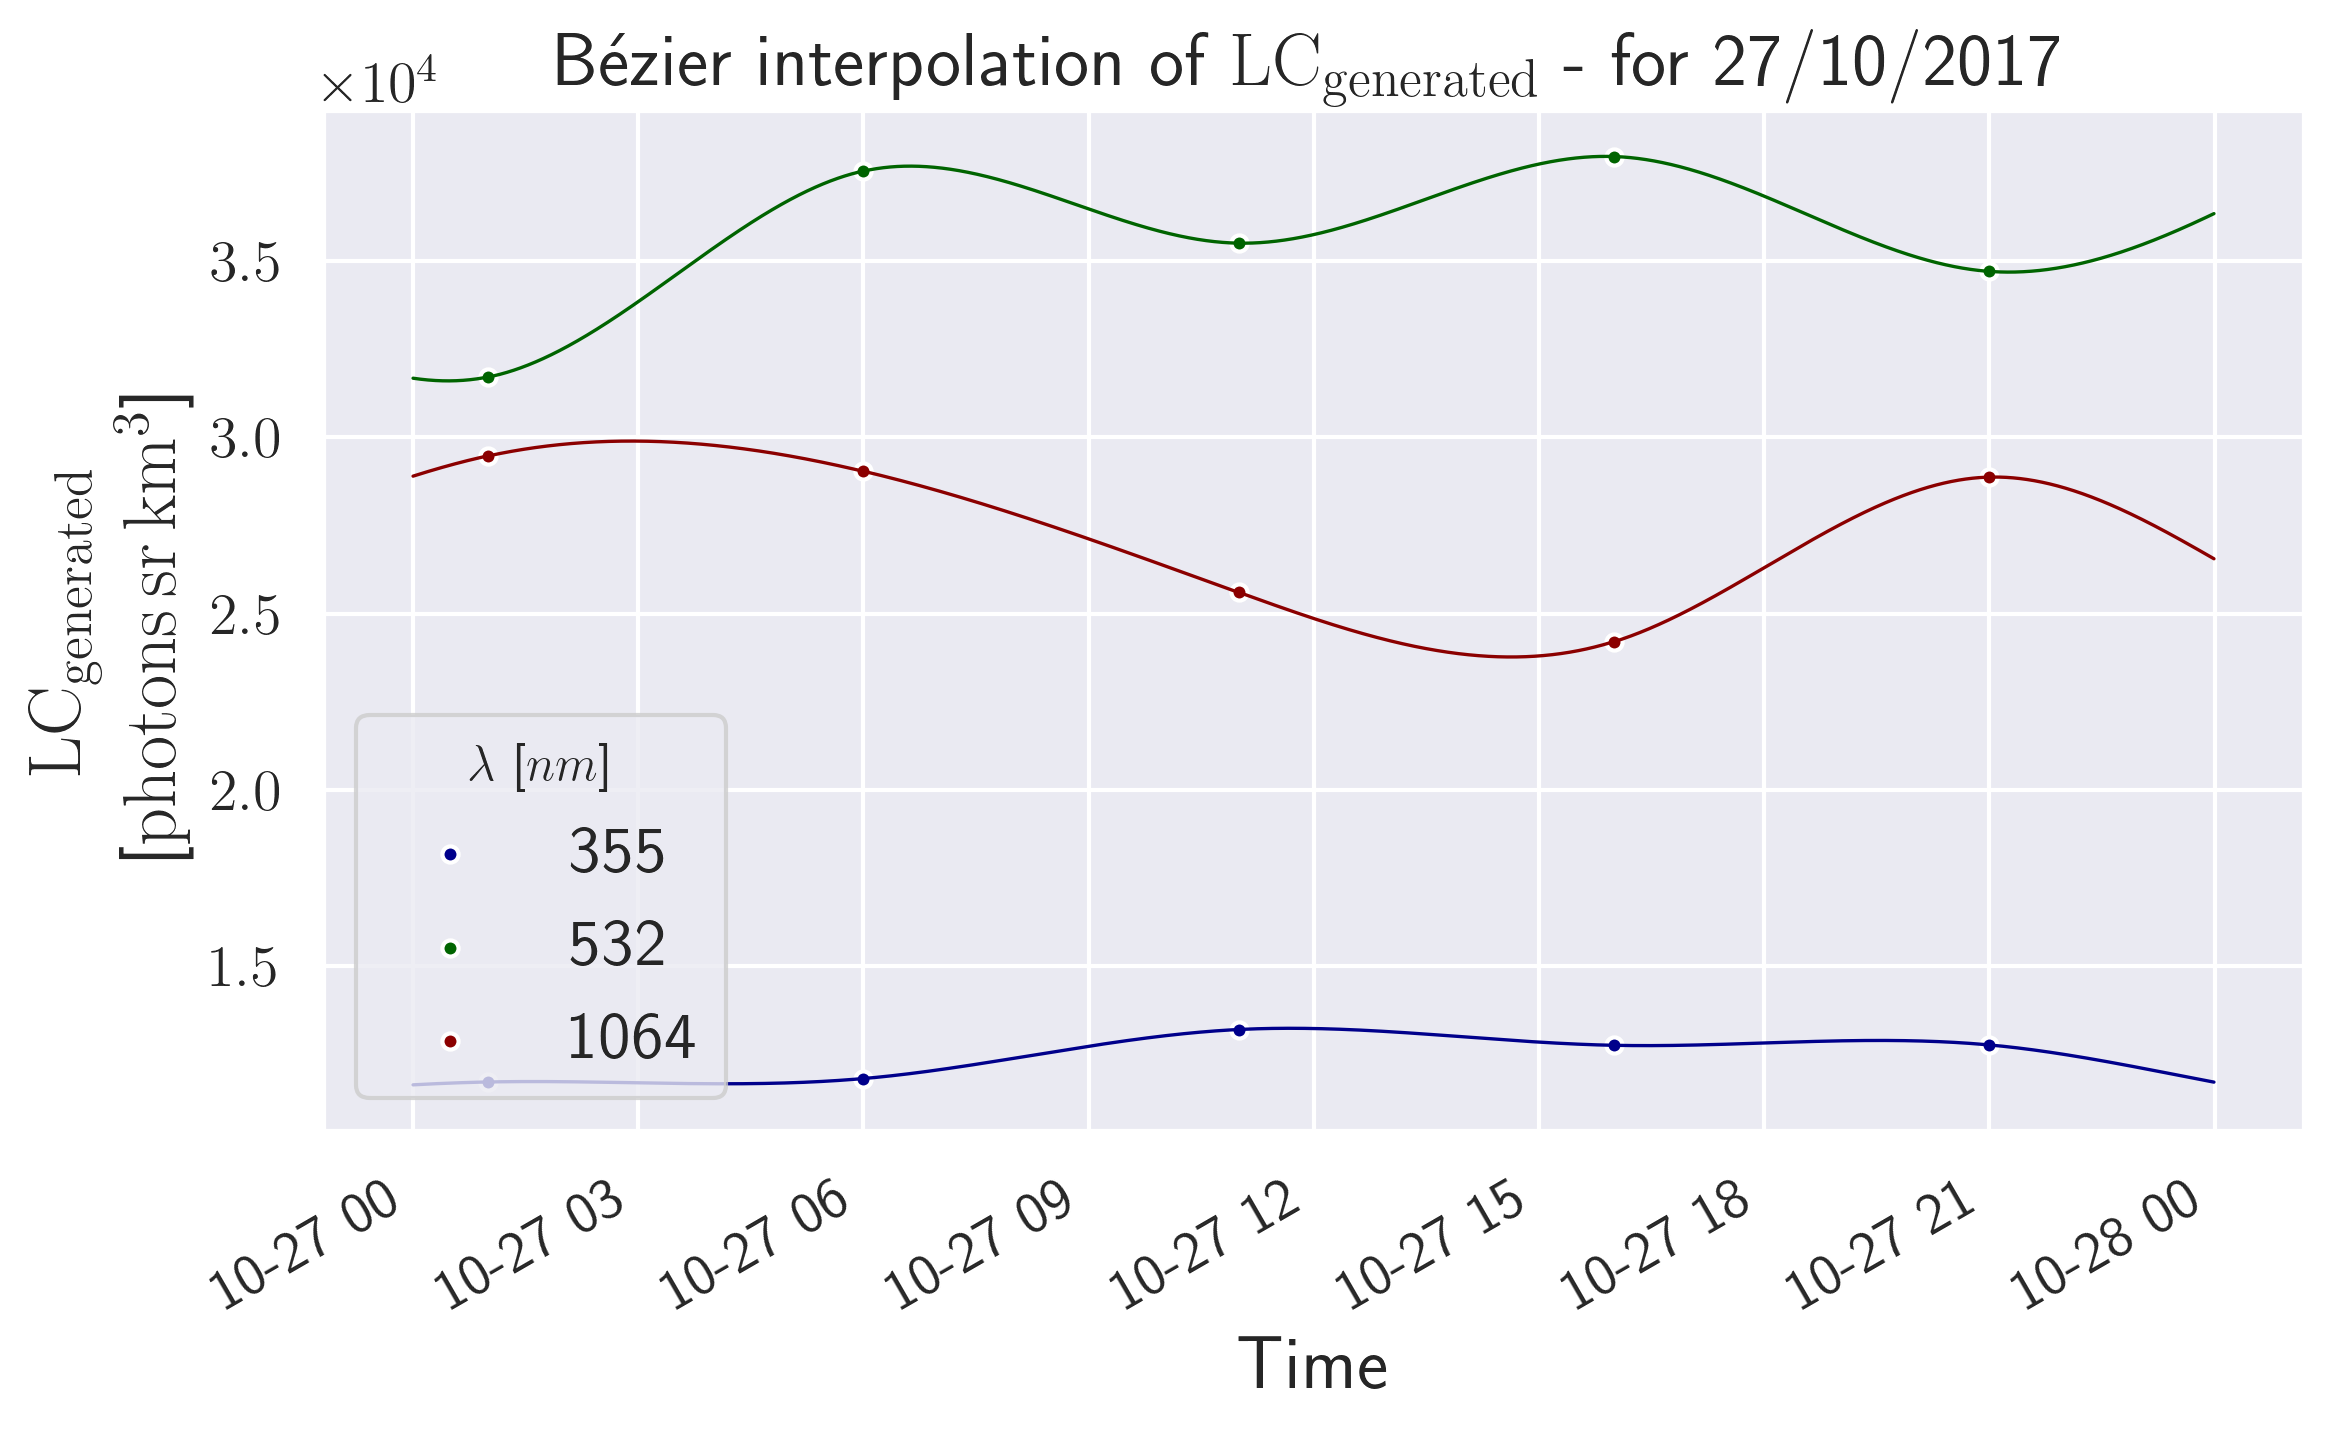

In [12]:
cur_days = datetime(2017,9,5),
curdays = [start_date+timedelta(days = 1*n*8) for n in range(8)]
for cur_day in curdays:
    day_slice = slice(cur_day,cur_day+timedelta(hours = 24)-timedelta(seconds = 30))
    fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(8,5))
    new_p.p.sel(Time=day_slice).plot(ax=ax,hue='Wavelength',linewidth=0.8)
    ds_gen_p.sel(Time=day_slice).plot.scatter(ax=ax,y='p_new',x='Time',hue='Wavelength',s=15,hue_style ='discrete',edgecolor='w')
    ax.ticklabel_format(axis='y', style="sci",scilimits=(0,0))
    ax.set_title(fr"B\'ezier interpolation of {new_p.p.long_name} - for {cur_day.strftime('%d/%m/%Y' )}")
    plt.tight_layout()
    plt.show()

In [ ]:
# %% Save monthly bg dataset
year = start_date.year
for month in range(start_date.month,end_date.month+1):
    _,monthdays = calendar.monthrange(year,month)
    start_dt = datetime(year,month,1)
    end_dt = datetime(year,month,monthdays) + timedelta(days=1) - timedelta(seconds =  station.freq)
    gen_source_path = gen_utils.get_month_gen_params_path(station,start_dt,type='LC')
    month_slice = slice(start_dt,end_dt)
    prep.save_dataset (dataset= new_p.sel(Time=month_slice) , nc_path=gen_source_path)
    print(gen_source_path)

In [ ]:
folder_name =  station.generation_folder
nc_name = f"generated_LC_{station.name}_" \
          f"{start_date.strftime('%Y-%m-%d')}_{end_date.strftime('%Y-%m-%d')}.nc"
prep.save_dataset ( new_p , folder_name , nc_name )